# Visualizing Loci
Uses GeneticsMakie.jl to produce LocusZoom style plots

### SCZ

In [1]:
using CairoMakie,CSV,DataFrames,Glob,SnpArrays
import GeneticsMakie as GM

gencodefilename = "/u/project/gandalm/shared/refGenomes/hg19/Gencode/v33/gencode.v33lift37.annotation.gtf"
sumstatsfilename = "/u/project/gandalm/shared/GWAS/SCZ.PGC3.2021/wave3_v3/PGC3_SCZ_wave3.european.autosome.public.v3.tsv"
ldfolder = "/u/project/gandalm/shared/apps/ldsc/LDSCORE/1000G_EUR_Phase3_plink"

function loaddata(gencodefilename::AbstractString, sumstatsfilename::AbstractString)
    gencode = CSV.read(gencodefilename, DataFrame; delim = '\t', comment = "#", 
                                        header = ["seqnames", "source", "feature", 
                                                  "start", "end", "score", "strand", 
                                                  "phase", "info"])
    GM.parsegtf!(gencode)
    sumstats = CSV.read(sumstatsfilename, DataFrame)
    GM.mungesumstats!(sumstats)
    return (gencode, sumstats)
end

gencode, sumstats = loaddata(gencodefilename, sumstatsfilename)

(2915984×14 DataFrame
     Row │ seqnames  source   feature      start  end    score    strand   pha ⋯
         │ String    String7  String15     Int64  Int64  String1  String1  Str ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │ 1         HAVANA   gene         11869  14409  .        +        .   ⋯
       2 │ 1         HAVANA   transcript   11869  14409  .        +        .
       3 │ 1         HAVANA   exon         11869  12227  .        +        .
       4 │ 1         HAVANA   exon         12613  12721  .        +        .
       5 │ 1         HAVANA   exon         13221  14409  .        +        .   ⋯
       6 │ 1         HAVANA   transcript   12010  13670  .        +        .
       7 │ 1         HAVANA   exon         12010  12057  .        +        .
       8 │ 1         HAVANA   exon         12179  12227  .        +        .
       9 │ 1         HAVANA   exon         12613  12697  .        +        .   ⋯
      10 │ 1         HAVANA   

In [2]:
# pgc3locuszoom
# saves LocusZoom style plot with PGC3 summary statistics
# @param chr::AbstractString - chromosome of the locus
# @param range1::Integer - base pair position of start of locus
# @param range1::Integer - base pair position of end of locus
# @param outpath::AbstractString - output path
# @param outname::AbstractString - filename for output, without extension
# @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
# @return - Makie figure visualizing the LocusZoom plot
# side effect - Saves image to <outpath>/<outname>.png
function pgc3locuszoom(chr::AbstractString, range1::Integer, range2::Integer, 
            outpath::AbstractString, outname::AbstractString; 
        snp::Union{AbstractString, Nothing} = nothing)
    ld = SnpData(joinpath(ldfolder, "1000G.EUR.QC.$(chr)"))
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    f = Figure(resolution = (500, 500))
    axs = [Axis(f[i,1]) for i in 1:2]
    if isnothing(snp)
        GM.plotlocus!(axs[1], chr, range1, range2, sumstats, ld = ld)
    else
        GM.plotlocus!(axs[1], chr, range1, range2, sumstats, ld = (ld, snp))
    end
    lines!(axs[1], [range1, range2], fill(-log(10, 5e-8), 2), color = (:purple, 0.5), linewidth = 0.5)
    Label(f[1, 1, Top()], "PGC3 SCZ", textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
    rowsize!(f.layout, 1, 30)
    rs = GM.plotgenes!(axs[2], chr, range1, range2, gencode)
    rowsize!(f.layout, 2, rs)
    Colorbar(f[1:2, 2], limits = (0, 1), ticks = 0:1:1, height = 20,
        colormap = (:gray60, :red2), label = "LD", ticksize = 0, tickwidth = 0,
        tickalign = 0, ticklabelsize = 6, flip_vertical_label = true,
        labelsize = 6, width = 5, spinewidth = 0.5)
    GM.labelgenome(f[2, 1, Bottom()], chr, range1, range2)
    Label(f[1, 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
    rowgap!(f.layout, 5)
    colgap!(f.layout, 5)
    resize_to_layout!(f)
    save(joinpath(outpath, outname * ".png"), f, px_per_unit = 4)
    return f
end



pgc3locuszoom (generic function with 1 method)

In [2]:
# coloclocuszoom
# saves LocusZoom style plot with PGC3 summary statistics and an array of provided eQTLs
# @param gene::AbstractString - gene to visualize
# @param colocfilenames::Array{<:AbstractString} - array of eQTL filenames to visualize
# @param colocthresholds::Array{<:Real} - array of signficance thresholds
# @param ldfilename::AbstractString - filename for the LD reference file
# @param outpath::AbstractString - output path
# @param outname::AbstractString - filename for output, without extension
# @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
# @return - Makie figure visualizing the LocusZoom plot
# side effect - Saves image to <outpath>/<outname>.png
function coloc(gene::AbstractString, colocfilenames::Array{<:AbstractString}, colocthresholds::Array{<:Real}, 
               ldfilename::AbstractString, outpath::AbstractString, outname::AbstractString;
               snp::Union{AbstractString, Nothing} = nothing)
    colocfiles = [CSV.read(file, DataFrame; header = 1) for file in colocfilenames]
    ld = SnpData(ldfilename)
    colocfiles = [innerjoin(df, ld.snp_info, on = :MarkerName => :snpid)
                   for df in colocfiles]
    colocfiles = DataFrame[colocfiles...]
    GM.mungesumstats!(colocfiles)
    chr, start, stop = GM.findgene(gene, gencode)
    range1 = start - 1e6
    range2 = stop + 1e6
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    f = Figure(resolution = (500, 1000))
    n = length(colocfiles)
    axs = [Axis(f[i,1]) for i in 1:(n+2)]
    # Visualize eQTLs
    for i in 1:n
        title = match(r"[^_]*", basename(colocfilenames[i])).match
        if isnothing(snp)
            GM.plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = ld)
        else
            GM.plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = (ld, snp))
        end
        lines!(axs[i], [range1, range2], fill(colocthresholds[i], 2), color = (:purple, 0.5), linewidth = 0.5)
        vlines!(axs[i], start, color = (:gold, 0.5), linewidth = 0.5)
        vlines!(axs[i], stop, color = (:gold, 0.5), linewidth = 0.5)
        Label(f[i, 1, Top()], title, textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
        rowsize!(f.layout, i, 50)
    end
    # Visualize PGC3
    ld = SnpData(joinpath(ldfolder, "1000G.EUR.QC.$(chr)"))
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    if isnothing(snp)
        GM.plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = ld)
    else
        GM.plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = (ld, snp))
    end
    lines!(axs[n + 1], [range1, range2], fill(7.3, 2), color = (:purple, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], stop, color = (:gold, 0.5), linewidth = 0.5)
    Label(f[n + 1, 1, Top()], "PGC3 SCZ", textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
    rowsize!(f.layout, n + 1, 30)
    # Visualize genes
    rs = GM.plotgenes!(axs[n + 2], chr, range1, range2, gencode)
    vlines!(axs[n + 2], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 2], stop, color = (:gold, 0.5), linewidth = 0.5)
    rowsize!(f.layout, n + 2, rs)
    Colorbar(f[1:(n+1), 2], limits = (0, 1), ticks = 0:1:1, height = 20,
        colormap = (:gray60, :red2), label = "LD", ticksize = 0, tickwidth = 0,
        tickalign = 0, ticklabelsize = 6, flip_vertical_label = true,
        labelsize = 6, width = 5, spinewidth = 0.5)
    GM.labelgenome(f[n + 2, 1, Bottom()], chr, range1, range2)
    Label(f[1:(n + 1), 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
    rowgap!(f.layout, 5)
    rowgap!(f.layout, 5)
    resize_to_layout!(f)
    save(joinpath(outpath, outname * ".png"), f, px_per_unit = 4)
    return f
end

coloc (generic function with 1 method)

In [6]:
GM.findgene("XKR6", gencode)

("8", 10753555, 11059342)

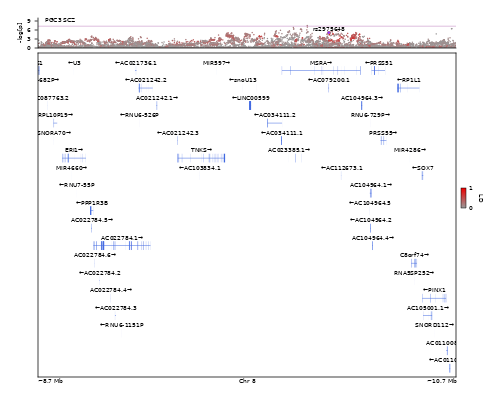

In [5]:
pgc3locuszoom("8", 8744650, 10744650, "../locuszoom/XKR6/", "locus232"; snp = "rs2975648")

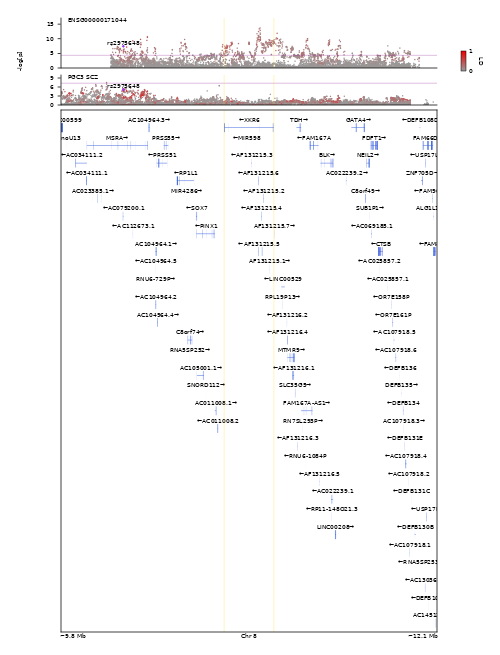

In [15]:
coloc("XKR6",
      ["../locuszoom/XKR6/ENSG00000171044_all_pairs.txt"],
      [4.388423],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/XKR6/",
      "XKR6"; snp = "rs2975648")

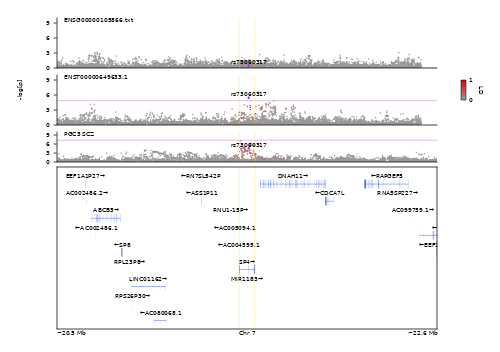

In [18]:
coloc("SP4",
      ["../locuszoom/SP4/ENSG00000105866.txt", "../locuszoom/SP4/ENST00000649633.1_1.txt"],
      [0,4.829568],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/SP4/",
      "SP4_gene_iso"; snp = "rs73060317")

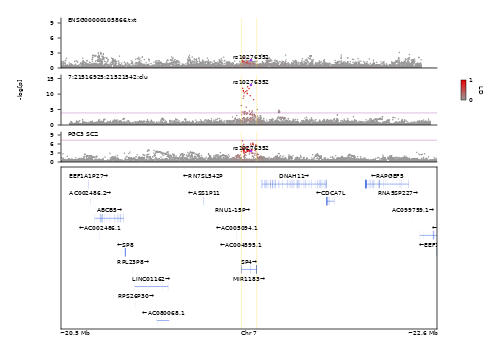

In [20]:
coloc("SP4",
      ["../locuszoom/SP4/ENSG00000105866.txt", "../locuszoom/SP4/7:21516925:21521542:clu_100938_NA.txt"],
      [0, 3.892946],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/SP4/",
      "SP4_gene_intron"; snp = "rs10276352")

In [21]:
glob("*header*", "../locuszoom/ASH1L/")

10-element Vector{String}:
 "../locuszoom/ASH1L/end_nominal_100hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/ex_nominal_90hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/in_nominal_90hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/ip_nominal_80hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/mic_nominal_80hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/mixed_nominal_90hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/opc_nominal_80hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/per_nominal_70hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/pg_nominal_80hcp.all_assoc_header.txt"
 "../locuszoom/ASH1L/rg_nominal_100hcp.all_assoc_header.txt"

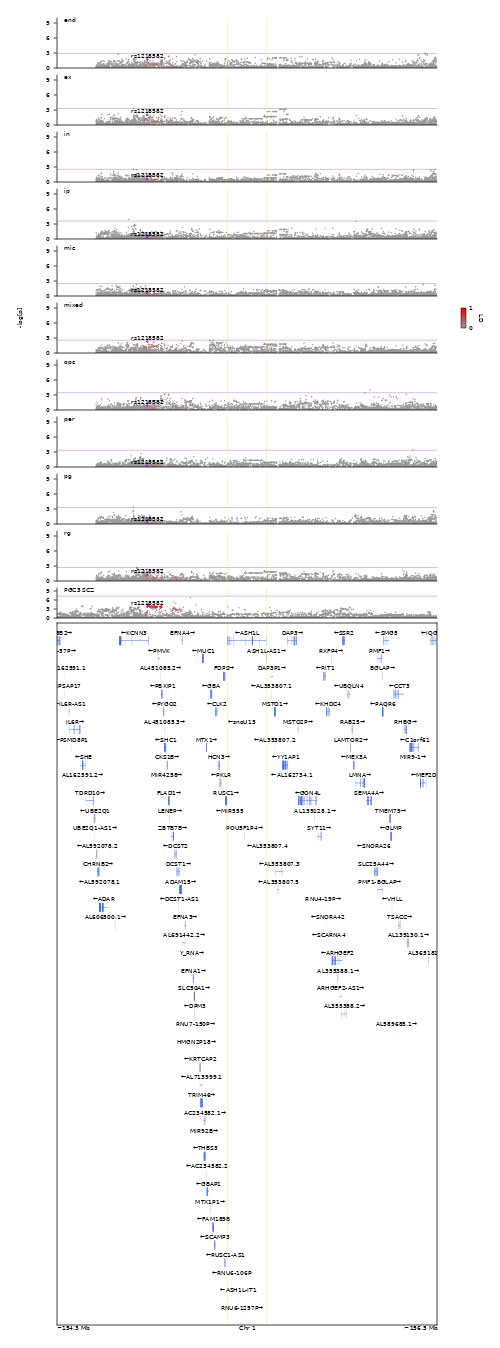

In [5]:
coloc("ASH1L",
      glob("*header*", "../locuszoom/ASH1L/"),
      [2.885169, 3.342502, 2.5605, 3.590351, 2.452831, 2.574151, 3.428784, 3.374539, 3.352088, 2.652098],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/ASH1L/",
      "ASH1L";
      snp = "rs1218582")

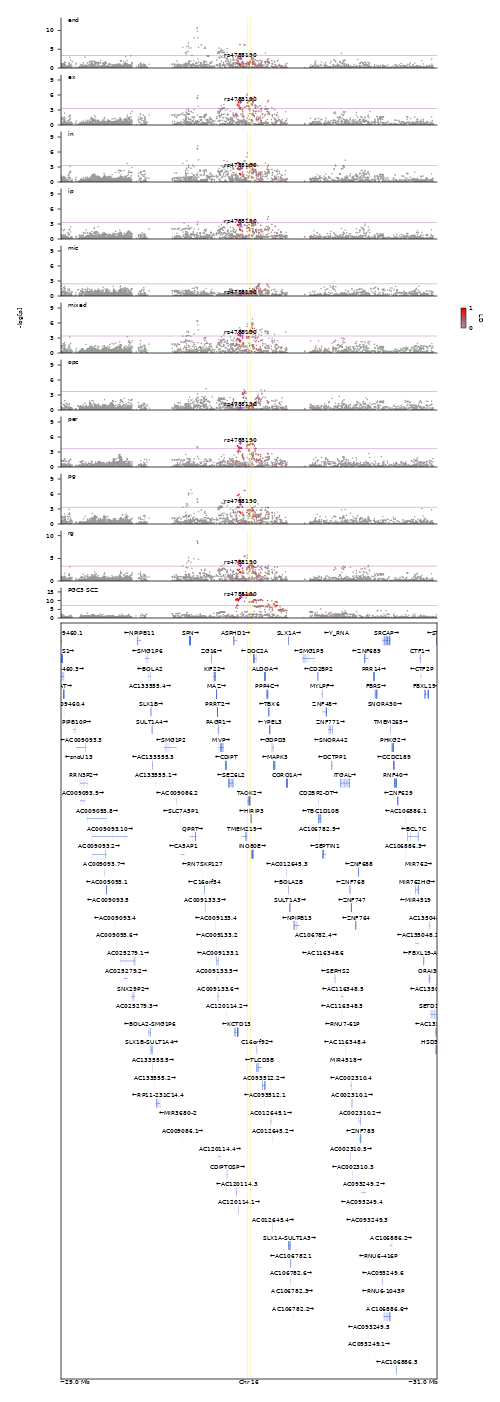

In [3]:
coloc("TAOK2",
      glob("*header*", "../locuszoom/TAOK2/"),
      [3.310969, 3.29006, 3.320197, 3.333095, 2.422212, 3.398259, 3.668182, 3.639337, 3.366927, 3.295616],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/TAOK2/",
      "TAOK2_rs4788190";
      snp = "rs4788190")

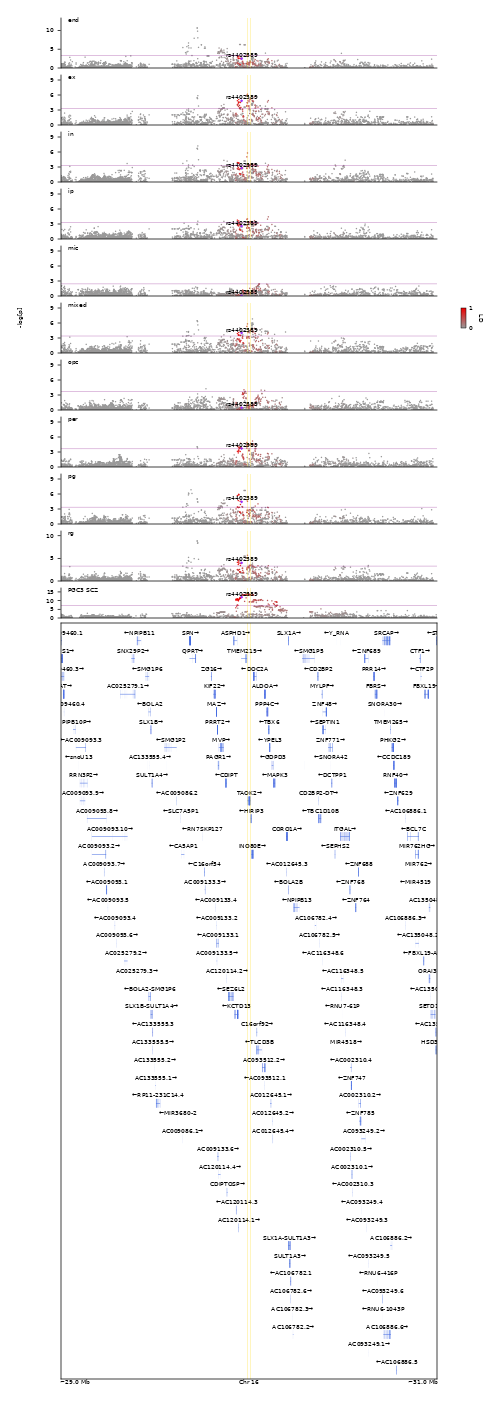

In [4]:
coloc("TAOK2",
      glob("*header*", "../locuszoom/TAOK2/"),
      [3.310969, 3.29006, 3.320197, 3.333095, 2.422212, 3.398259, 3.668182, 3.639337, 3.366927, 3.295616],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/TAOK2/",
      "TAOK2_rs4402589";
      snp = "rs4402589")

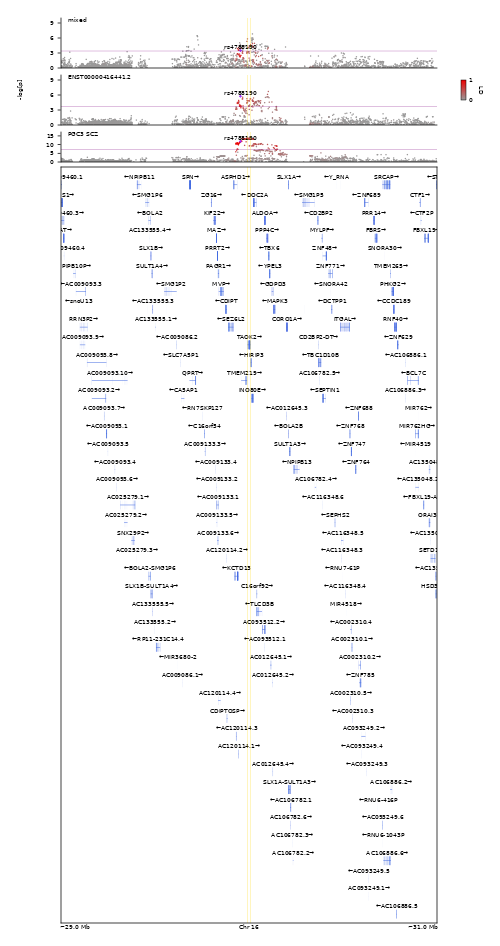

In [7]:
coloc("TAOK2",
      ["../locuszoom/TAOK2/mixed_nominal_90hcp.all_assoc_header.txt", "../locuszoom/TAOK2/ENST00000416441.2_1.txt"],
      [3.398259,3.675434],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/TAOK2/",
      "TAOK2_gene_iso"; snp = "rs4788190")

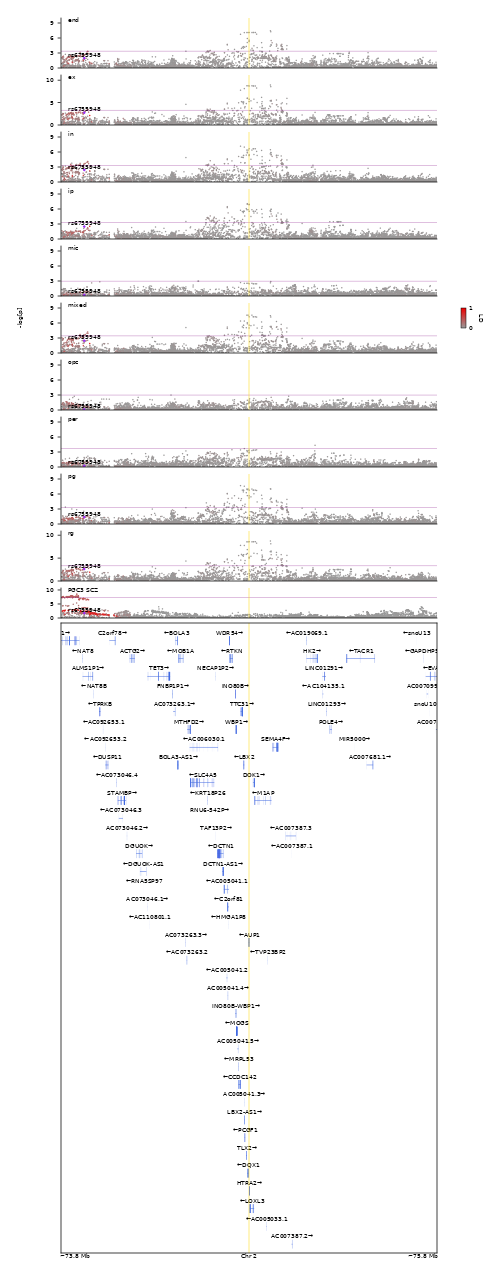

In [3]:
coloc("AUP1",
      glob("*header*", "../locuszoom/AUP1/"),
      [3.373993, 3.297113, 3.340225, 3.340164, 2.973826, 3.419828, 2.990231, 3.677632, 3.335806, 3.311610],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/AUP1/",
      "AUP1_rs6755948";
      snp = "rs6755948")

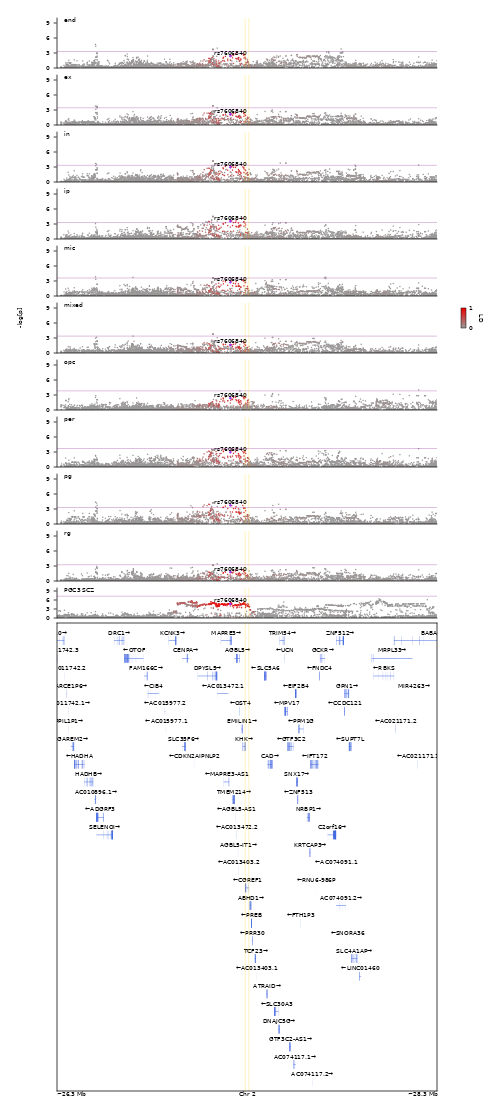

In [4]:
coloc("CGREF1",
      glob("*header*", "../locuszoom/CGREF1/"),
      [3.324282, 3.423089, 3.367066, 3.319355, 3.599443, 3.388455, 3.814042, 3.667045, 3.339667, 3.227079],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CGREF1/",
      "CGREF1_rs7606840";
      snp = "rs7606840")

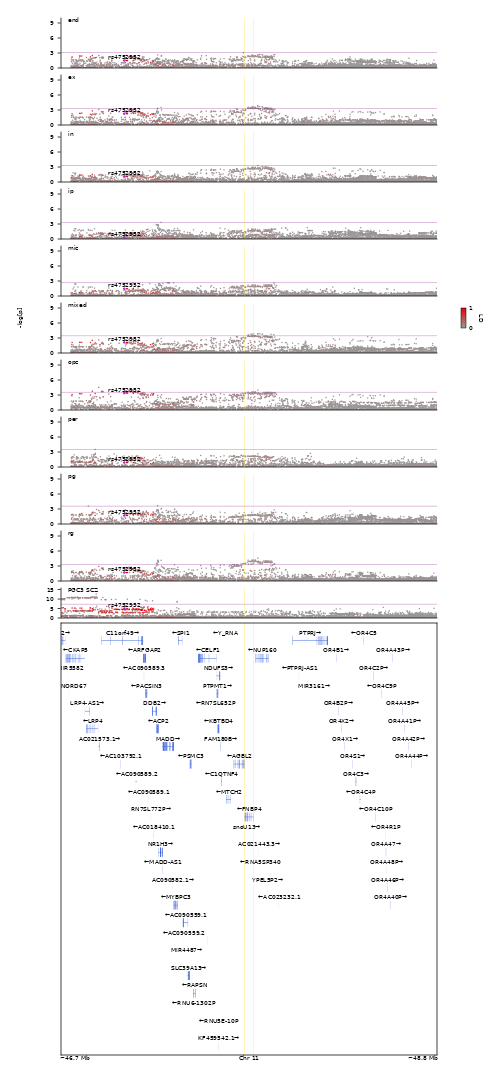

In [5]:
coloc("FNBP4",
      glob("*header*", "../locuszoom/FNBP4/"),
      [3.063471, 3.314909, 3.300560, 3.317185, 2.644865, 3.429557, 3.563251, 3.520586, 3.580423, 3.301119],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/FNBP4/",
      "FNBP4_rs4752952";
      snp = "rs4752952")

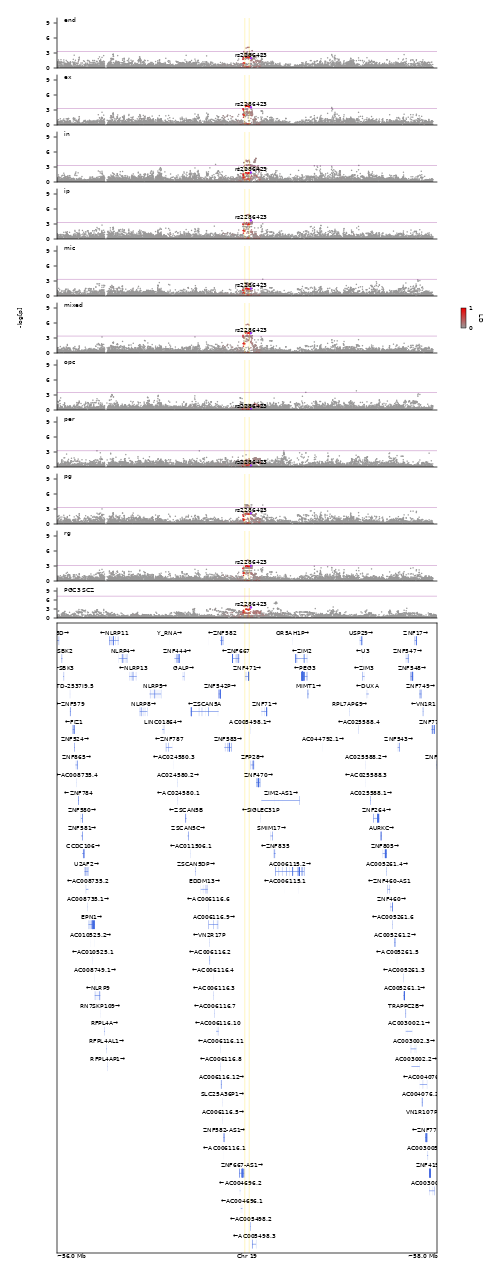

In [6]:
coloc("ZNF471",
      glob("*header*", "../locuszoom/ZNF471/"),
      [3.297976, 3.287040, 3.349675, 3.336276, 3.359042, 3.390543, 3.532444, 3.233396, 3.337052, 3.072672],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/ZNF471/",
      "ZNF471_rs2286423";
      snp = "rs2286423")

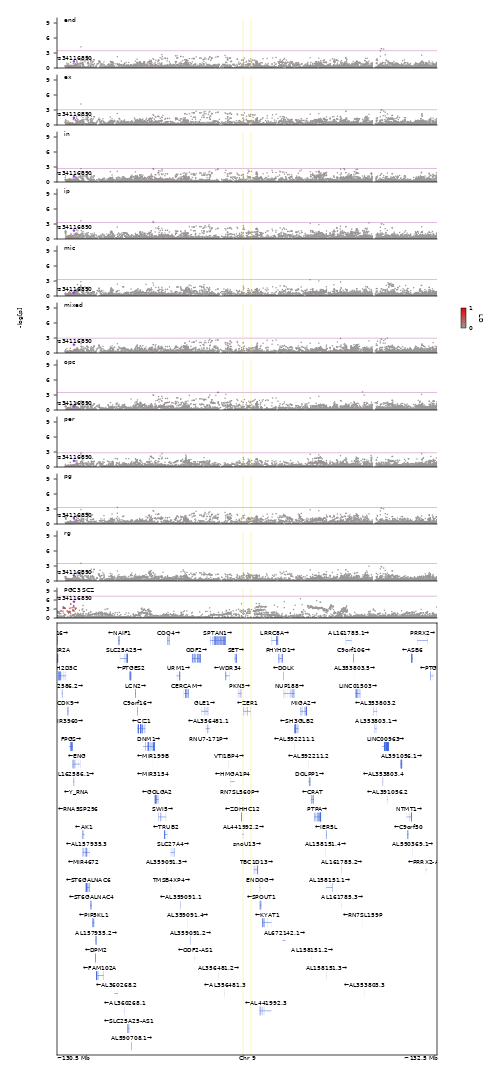

In [7]:
coloc("ZER1",
      glob("*header*", "../locuszoom/ZER1/"),
      [3.431412, 3.027056, 2.700329, 3.342964, 3.251662, 2.981924, 3.545574, 2.823024, 3.311249, 3.534421],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/ZER1/",
      "ZER1_rs34116890";
      snp = "rs34116890")

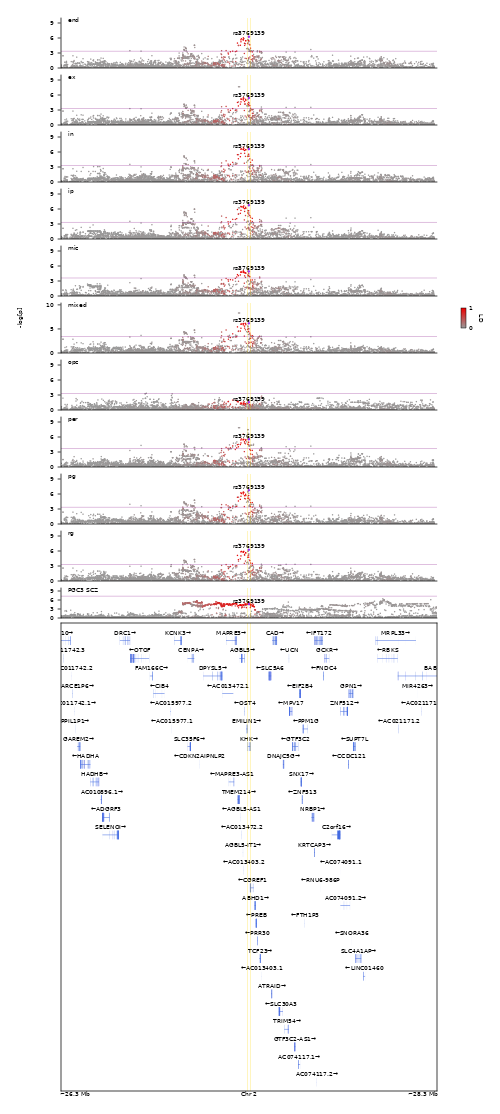

In [4]:
coloc("KHK",
      glob("*header*", "../locuszoom/KHK/"),
      [3.373824, 3.278956, 3.321339, 3.355537, 3.601229, 3.384468, 3.349051, 3.649417, 3.370173, 3.323773],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/KHK/",
      "KHK_rs3769139";
      snp = "rs3769139")

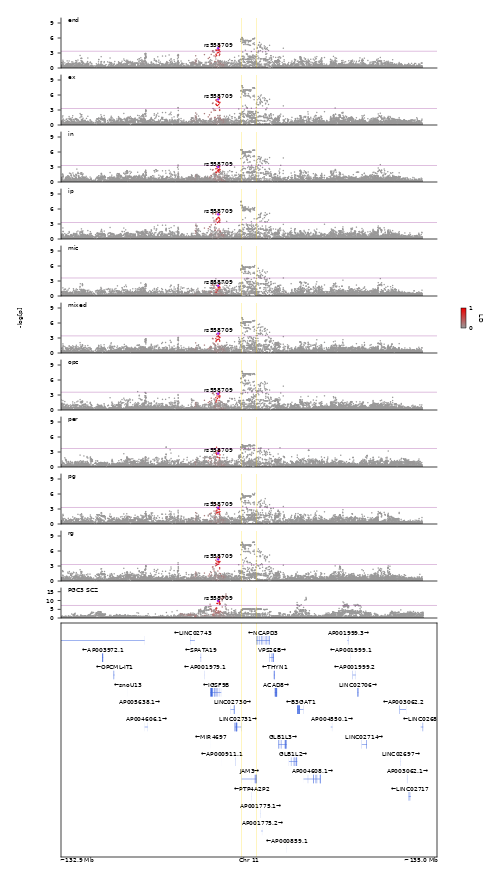

In [3]:
coloc("JAM3",
      glob("*header*", "../locuszoom/JAM3/"),
      [3.376701, 3.288453, 3.336101, 3.318112, 3.602402, 3.412782, 3.578999, 3.654328, 3.352207, 3.320649],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/JAM3/",
      "JAM3_rs558709";
      snp = "rs558709")

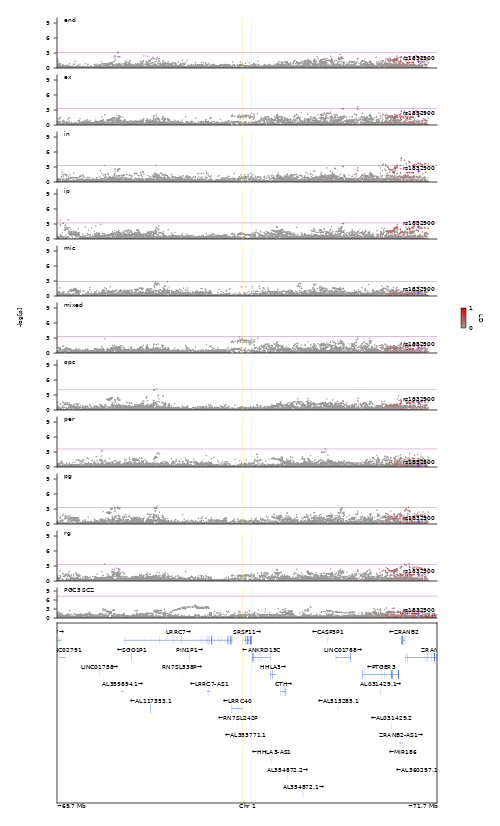

In [4]:
coloc("SRSF11",
      glob("*header*", "../locuszoom/SRSF11/"),
      [3.099095, 3.263525, 3.332658, 3.209744, 2.856089, 3.278239, 4.026385, 3.606725, 3.334091, 3.306896],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/SRSF11/",
      "SRSF11_rs1832900";
      snp = "rs1832900")

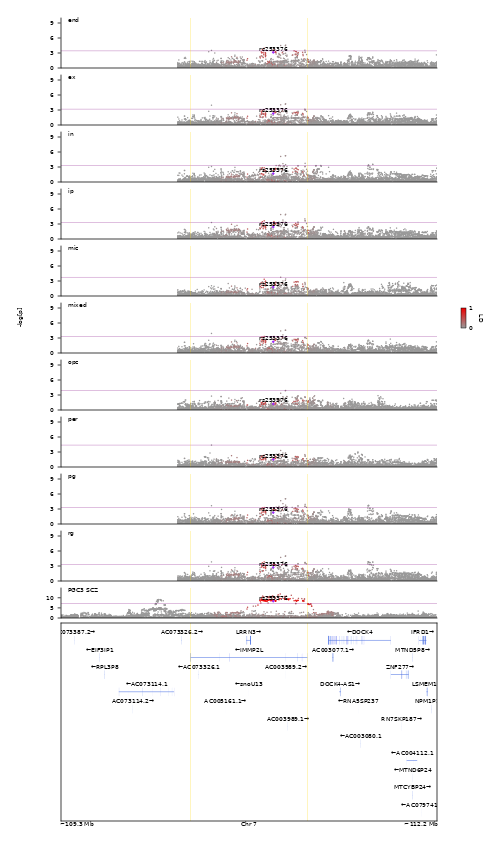

In [3]:
coloc("IMMP2L",
      glob("*header*", "../locuszoom/IMMP2L/"),
      [3.42255990496454, 3.17785481326375, 3.34771303646844, 3.34497784100125, 3.75434916955722, 3.30655446659367, 3.85745098812893, 4.38586135318412, 3.33872886426466, 3.29739715865957],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/IMMP2L/",
      "IMMP2L_rs253376";
      snp = "rs253376")

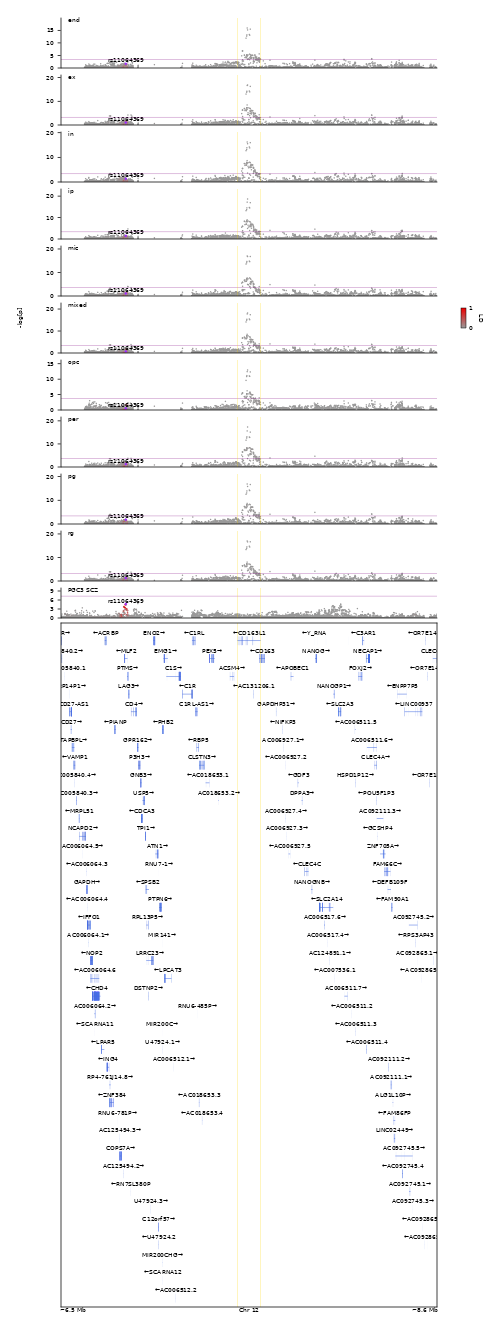

In [4]:
coloc("CD163L1",
      glob("*header*", "../locuszoom/CD163L1/"),
      [3.37068012357883, 3.27711445697898, 3.33620581964776, 3.34441117024912, 3.60464914032509, 3.38314444783924, 3.65455961084399, 3.65121631382123, 3.39636096511209, 3.28682205980428],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CD163L1/",
      "CD163L1_rs11064369";
      snp = "rs11064369")

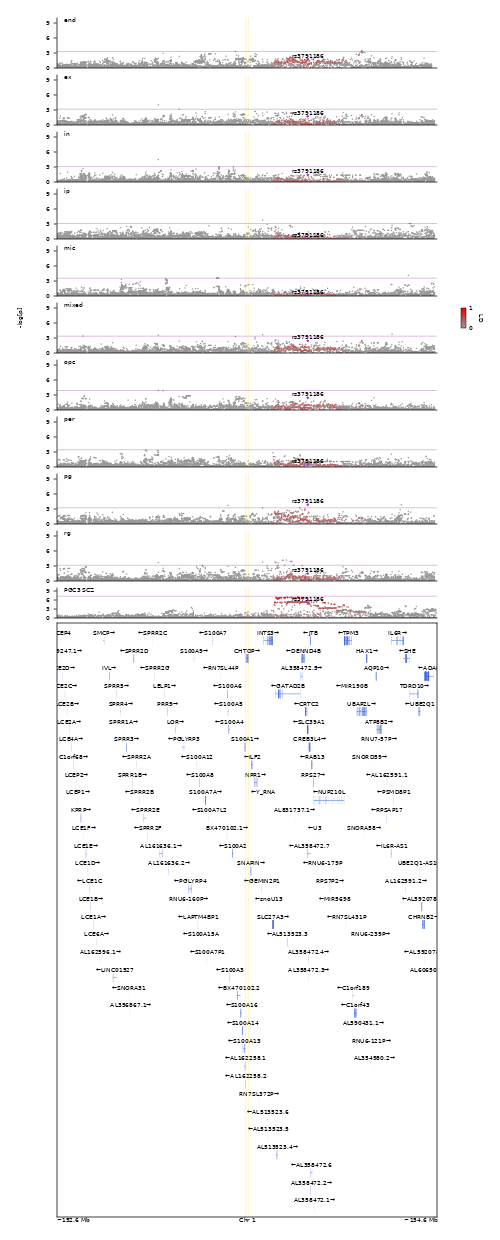

In [5]:
coloc("CHTOP",
      glob("*header*", "../locuszoom/CHTOP/"),
      [3.33628023360985, 3.17918334266656, 3.03806280572218, 3.09392259385665, 3.58347265692425, 3.38200946420228, 3.8871035559994, 3.42636035288218, 3.2174951274408, 3.17298567503708],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CHTOP/",
      "CHTOP_rs3791186";
      snp = "rs3791186")

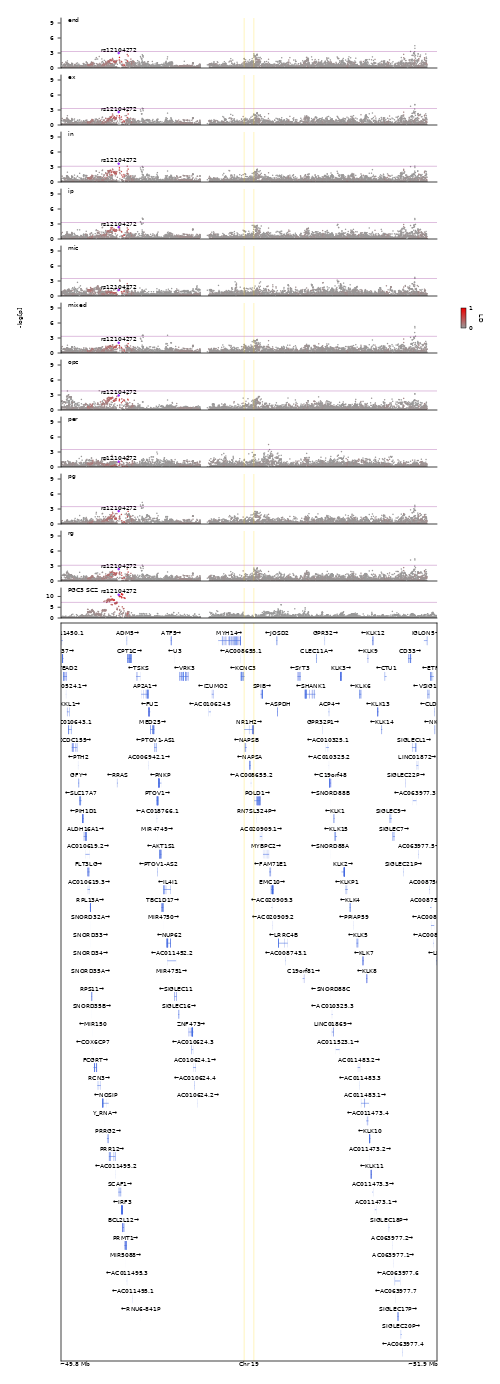

In [4]:
coloc("NR1H2",
      glob("*header*", "../locuszoom/NR1H2/"),
      [3.30351867127043, 3.25604989270212, 3.1740010434059, 3.31153390318185, 3.5185573714977, 3.36617011944733, 3.80404226113073, 3.47584803429511, 3.43974297012699, 3.17402503168388],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/NR1H2/",
      "NR1H2_rs12104272";
      snp = "rs12104272")

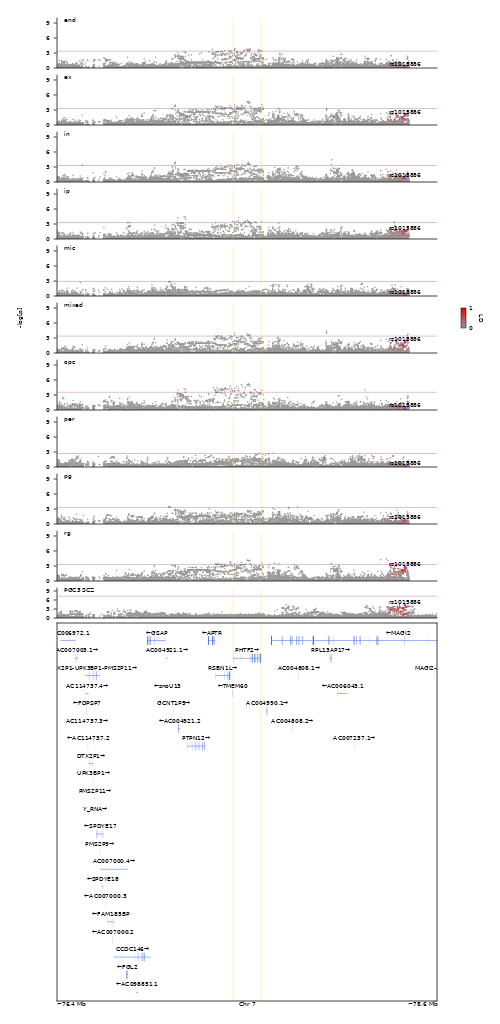

In [5]:
coloc("PHTF2",
      glob("*header*", "../locuszoom/PHTF2/"),
      [3.38111551500455, 3.28850236880893, 3.29360827419895, 3.33076031353592, 2.92522742970002, 3.39055927497947, 3.57248954772538, 2.74519582025899, 3.32734069440113, 3.30106647793274],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/PHTF2/",
      "PHTF2_rs1015886";
      snp = "rs1015886")

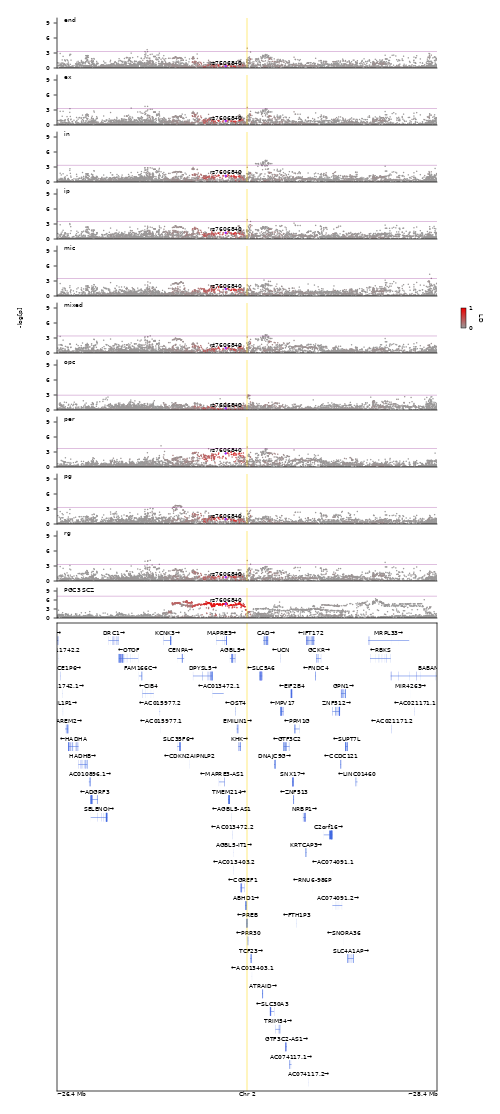

In [6]:
coloc("PREB",
      glob("*header*", "../locuszoom/PREB/"),
      [3.2751959235527, 3.26534655951897, 3.36652447456779, 3.51099266839095, 3.52818041388963, 3.40357775684019, 2.97871971542724, 3.6582015724138, 3.35283423143124, 3.32501859562535],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/PREB/",
      "PREB_rs7606840";
      snp = "rs7606840")

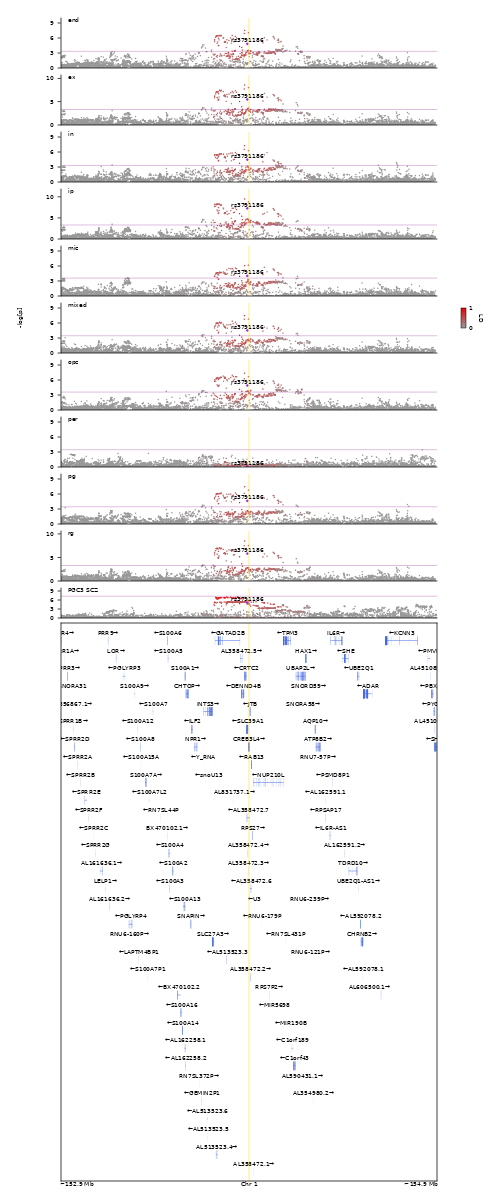

In [7]:
coloc("CREB3L4",
      glob("*header*", "../locuszoom/CREB3L4/"),
      [3.36542499938684, 3.28690781282329, 3.35442349506973, 3.32494975738652, 3.59276890450297, 3.42545714527902, 3.59075350305601, 3.4278268494696, 3.42190198988721, 3.34457821323664],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CREB3L4/",
      "CREB3L4_rs3791186";
      snp = "rs3791186")

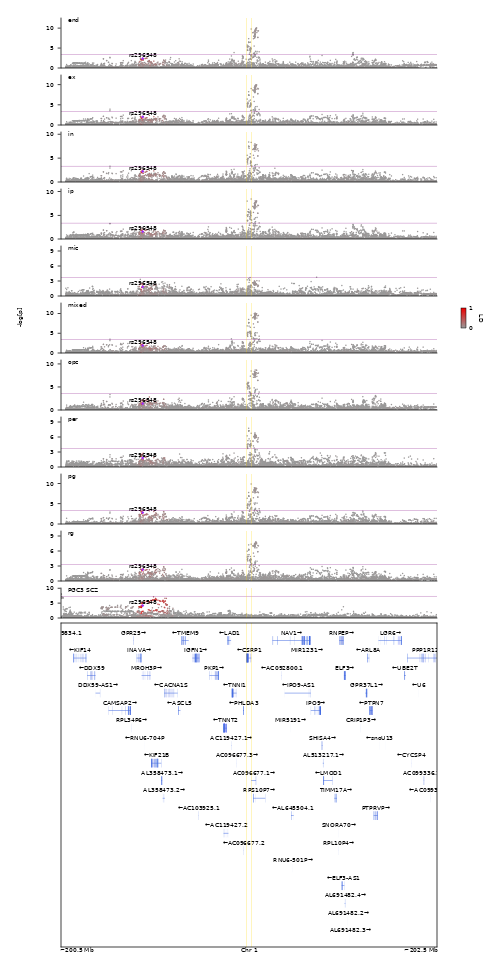

In [8]:
coloc("CSRP1",
      glob("*header*", "../locuszoom/CSRP1/"),
      [3.37710863298303, 3.34707711243206, 3.30482050844771, 3.35245273332475, 3.69088106804444, 3.37295383622933, 3.57568200564555, 3.7136670545218, 3.33482347571598, 3.32561840874422],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CSRP1/",
      "CSRP1_rs296548";
      snp = "rs296548")

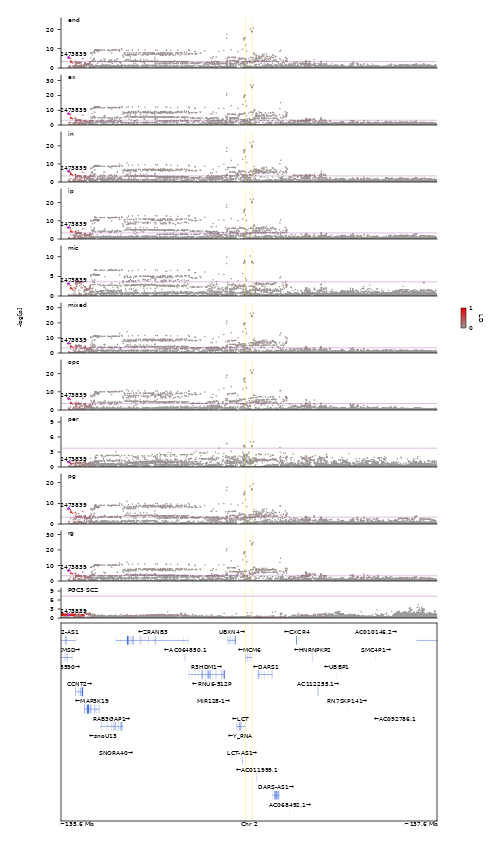

In [10]:
coloc("MCM6",
      glob("*header*", "../locuszoom/MCM6/"),
      [3.36881505831544, 3.28819361424988, 3.3462435112938, 3.33705527308774, 3.5861288188798, 3.39586794619175, 3.57166431022054, 3.78087935306151, 3.35669342895866, 3.30297913373849],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/MCM6/",
      "MCM6_rs12473839";
      snp = "rs12473839")

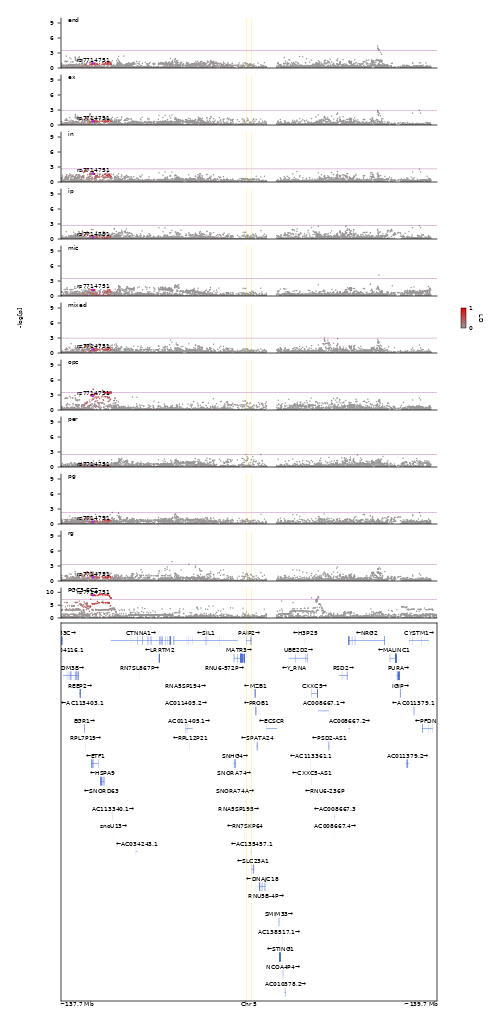

In [11]:
coloc("PAIP2",
      glob("*header*", "../locuszoom/PAIP2/"),
      [3.55537601042637, 2.96049863407574, 2.61805144079248, 2.67013045030665, 3.44925447171957, 2.98747912433048, 3.54114770022068, 2.51274988233896, 2.30681581863507, 3.32012894942137],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/PAIP2/",
      "PAIP2_rs7714751";
      snp = "rs7714751")

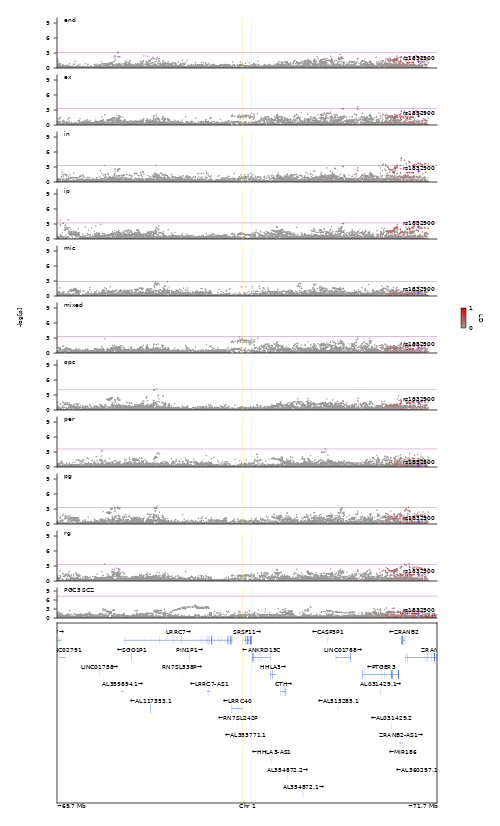

In [9]:
coloc("SRSF11",
      glob("*header*", "../locuszoom/SRSF11/"),
      [3.09909457067466, 3.26352461469746, 3.33265820336257, 3.20974369604033, 2.85608941546208, 3.27823883289445, 4.02638499347128, 3.60672495844026, 3.33409083264287, 3.30689592768407],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/SRSF11/",
      "SRSF11_rs1832900";
      snp = "rs1832900")

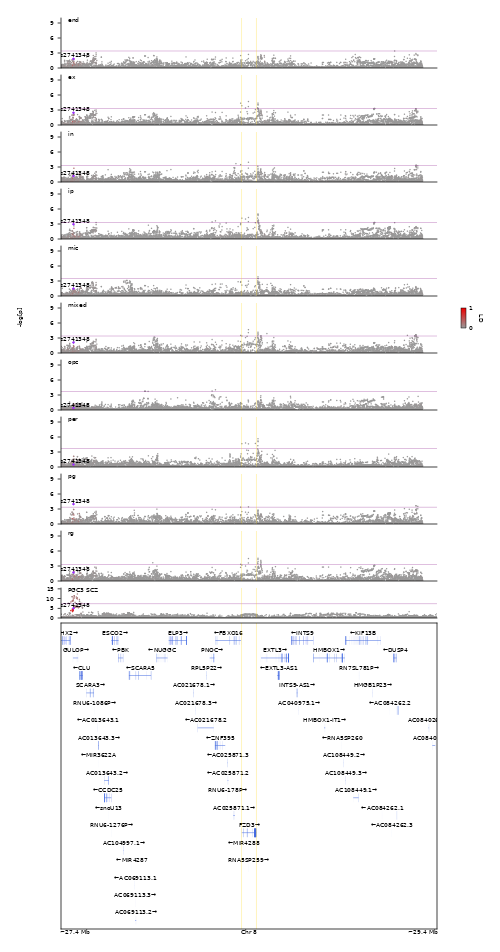

In [12]:
coloc("FZD3",
      glob("*header*", "../locuszoom/FZD3/"),
      [3.40145788881113, 3.29641202695173, 3.3407895075757, 3.28928028930211, 3.51159454263234, 3.3985538832788, 3.69110705544851, 3.67493816100749, 3.37422879772222, 3.26832744581654],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/FZD3/",
      "FZD3_rs2741348";
      snp = "rs2741348")

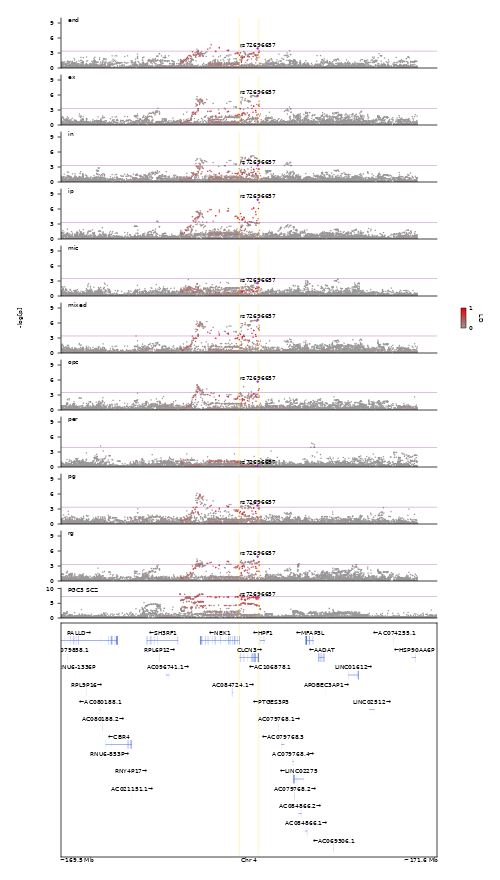

In [14]:
coloc("CLCN3",
      glob("*header*", "../locuszoom/CLCN3/"),
      [3.38469924629436, 3.31546521609751, 3.34847098205335, 3.3266537244385, 3.53034290001456, 3.40501774011686, 3.54377824949188, 3.93885299162503, 3.37485635979285, 3.3066468458083],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CLCN3/",
      "CLCN3_rs72696657";
      snp = "rs72696657")

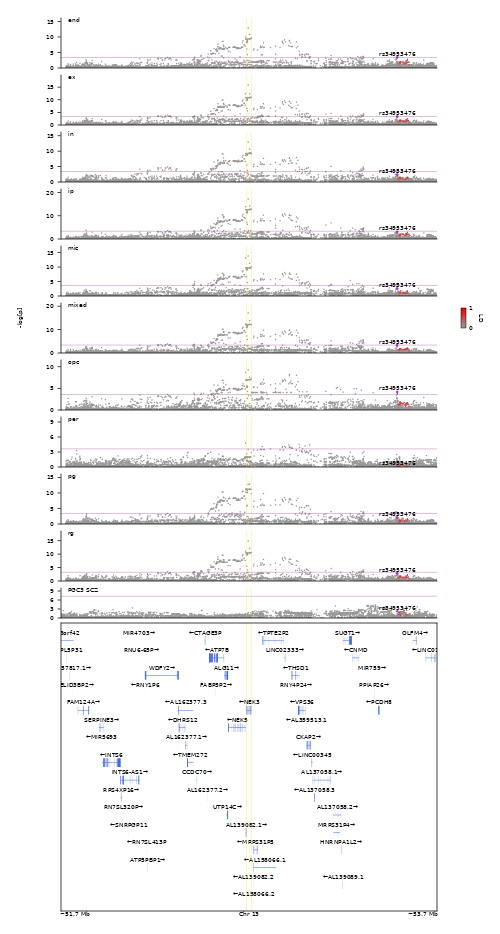

In [15]:
coloc("NEK3",
      glob("*header*", "../locuszoom/NEK3/"),
      [3.36247224636799, 3.2929342389394, 3.34808748792568, 3.38629556793769, 3.58367909122781, 3.40585395129633, 3.55607863623973, 3.61494096037635, 3.3664588314318, 3.29899099983512],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/NEK3/",
      "NEK3_rs34953476";
      snp = "rs34953476")

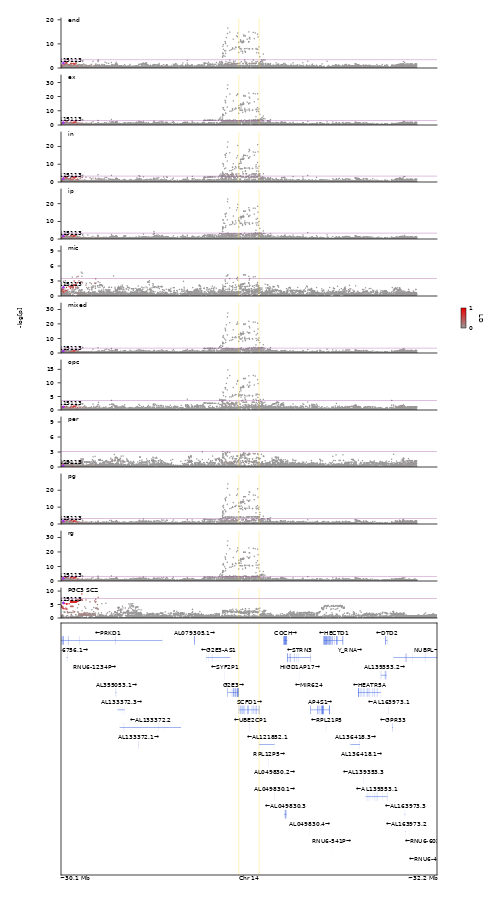

In [16]:
coloc("SCFD1",
      glob("*header*", "../locuszoom/SCFD1/"),
      [3.38723521028582, 3.29189367356678, 3.33525181389019, 3.36406510282246, 3.48029404568627, 3.38556895193423, 3.54188361729504, 3.0797921197941, 3.33961269872436, 3.28532998061005],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/SCFD1/",
      "SCFD1_rs17115113";
      snp = "rs17115113")

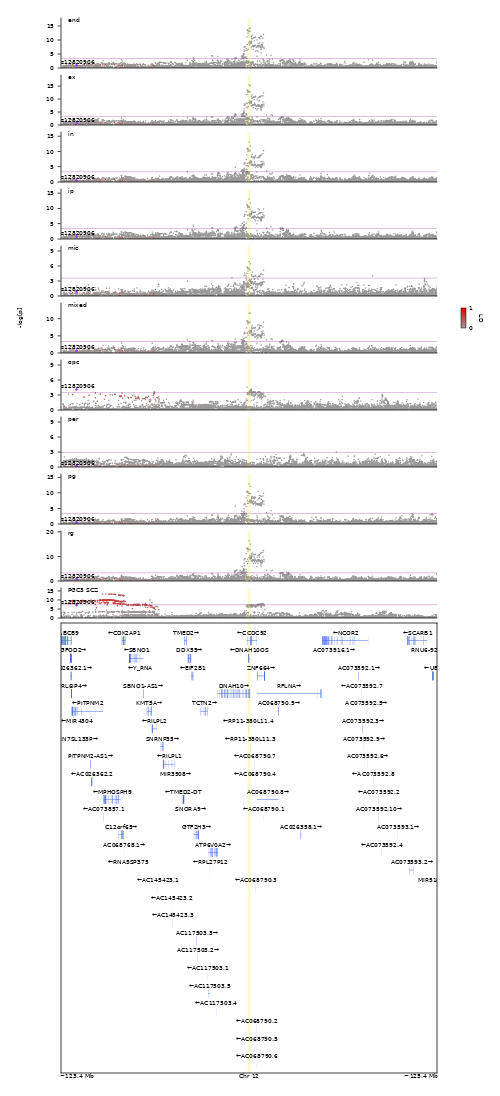

In [3]:
coloc("DNAH10OS",
      glob("*header*", "../locuszoom/DNAH10OS/"),
      [3.38132028120733, 3.26818407522664, 3.32574159694468, 3.33966111500169, 3.58934759151756, 3.42224632373166, 3.55280939779303, 2.95338779093155, 3.34802747656379, 3.28839436411108],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/DNAH10OS/",
      "DNAH10OS_rs12820906";
      snp = "rs12820906")

In [ ]:
coloc("LAMTOR5P1",
      glob("*header*", "../locuszoom/LAMTOR5P1/"),
      [],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/LAMTOR5P1/",
      "LAMTOR5P1_rs2485750";
      snp = "rs2485750")

In [ ]:
coloc("LDHAP4",
      glob("*header*", "../locuszoom/LDHAP4/"),
      [],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/LDHAP4/",
      "LDHAP4_rs6474840";
      snp = "rs6474840")

In [ ]:
coloc("TP73-AS1",
      glob("*header*", "../locuszoom/TP73-AS1/"),
      [],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/TP73-AS1/",
      "TP73-AS1_rs58429922";
      snp = "rs58429922")

### BIP

In [1]:
using CairoMakie,CSV,DataFrames,Glob,SnpArrays
import GeneticsMakie as GM

gencodefilename = "/u/project/gandalm/shared/refGenomes/hg19/Gencode/v33/gencode.v33lift37.annotation.gtf"
sumstatsfilename = "/u/project/gandalm/shared/GWAS/BIP.Mullins.2021/pgc-bip2021-all.tsv.gz"
ldfolder = "/u/project/gandalm/shared/apps/ldsc/LDSCORE/1000G_EUR_Phase3_plink"

function loaddata(gencodefilename::AbstractString, sumstatsfilename::AbstractString)
    gencode = CSV.read(gencodefilename, DataFrame; delim = '\t', comment = "#", 
                                        header = ["seqnames", "source", "feature", 
                                                  "start", "end", "score", "strand", 
                                                  "phase", "info"])
    GM.parsegtf!(gencode)
    sumstats = CSV.read(sumstatsfilename, DataFrame)
    GM.mungesumstats!(sumstats)
    return (gencode, sumstats)
end

gencode, sumstats = loaddata(gencodefilename, sumstatsfilename)

(2915984×14 DataFrame
     Row │ seqnames  source   feature      start  end    score    strand   pha ⋯
         │ String    String7  String15     Int64  Int64  String1  String1  Str ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │ 1         HAVANA   gene         11869  14409  .        +        .   ⋯
       2 │ 1         HAVANA   transcript   11869  14409  .        +        .
       3 │ 1         HAVANA   exon         11869  12227  .        +        .
       4 │ 1         HAVANA   exon         12613  12721  .        +        .
       5 │ 1         HAVANA   exon         13221  14409  .        +        .   ⋯
       6 │ 1         HAVANA   transcript   12010  13670  .        +        .
       7 │ 1         HAVANA   exon         12010  12057  .        +        .
       8 │ 1         HAVANA   exon         12179  12227  .        +        .
       9 │ 1         HAVANA   exon         12613  12697  .        +        .   ⋯
      10 │ 1         HAVANA   

In [2]:
# coloclocuszoom
# saves LocusZoom style plot with PGC3 summary statistics and an array of provided eQTLs
# @param gene::AbstractString - gene to visualize
# @param colocfilenames::Array{<:AbstractString} - array of eQTL filenames to visualize
# @param colocthresholds::Array{<:Real} - array of signficance thresholds
# @param ldfilename::AbstractString - filename for the LD reference file
# @param outpath::AbstractString - output path
# @param outname::AbstractString - filename for output, without extension
# @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
# @return - Makie figure visualizing the LocusZoom plot
# side effect - Saves image to <outpath>/<outname>.png
function coloc(gene::AbstractString, colocfilenames::Array{<:AbstractString}, colocthresholds::Array{<:Real}, 
               ldfilename::AbstractString, outpath::AbstractString, outname::AbstractString;
               snp::Union{AbstractString, Nothing} = nothing)
    colocfiles = [CSV.read(file, DataFrame; header = 1) for file in colocfilenames]
    ld = SnpData(ldfilename)
    colocfiles = [innerjoin(df, ld.snp_info, on = :MarkerName => :snpid)
                   for df in colocfiles]
    colocfiles = DataFrame[colocfiles...]
    GM.mungesumstats!(colocfiles)
    chr, start, stop = GM.findgene(gene, gencode)
    range1 = start - 1e6
    range2 = stop + 1e6
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    f = Figure(resolution = (500, 1000))
    n = length(colocfiles)
    axs = [Axis(f[i,1]) for i in 1:(n+2)]
    # Visualize eQTLs
    for i in 1:n
        title = match(r"[^_]*", basename(colocfilenames[i])).match
        if isnothing(snp)
            GM.plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = ld)
        else
            GM.plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = (ld, snp))
        end
        lines!(axs[i], [range1, range2], fill(colocthresholds[i], 2), color = (:purple, 0.5), linewidth = 0.5)
        vlines!(axs[i], start, color = (:gold, 0.5), linewidth = 0.5)
        vlines!(axs[i], stop, color = (:gold, 0.5), linewidth = 0.5)
        Label(f[i, 1, Top()], title, textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
        rowsize!(f.layout, i, 50)
    end
    # Visualize PGC3
    ld = SnpData(joinpath(ldfolder, "1000G.EUR.QC.$(chr)"))
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    if isnothing(snp)
        GM.plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = ld)
    else
        GM.plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = (ld, snp))
    end
    lines!(axs[n + 1], [range1, range2], fill(7.3, 2), color = (:purple, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], stop, color = (:gold, 0.5), linewidth = 0.5)
    Label(f[n + 1, 1, Top()], "BIP", textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
    rowsize!(f.layout, n + 1, 30)
    # Visualize genes
    rs = GM.plotgenes!(axs[n + 2], chr, range1, range2, gencode)
    vlines!(axs[n + 2], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 2], stop, color = (:gold, 0.5), linewidth = 0.5)
    rowsize!(f.layout, n + 2, rs)
    Colorbar(f[1:(n+1), 2], limits = (0, 1), ticks = 0:1:1, height = 20,
        colormap = (:gray60, :red2), label = "LD", ticksize = 0, tickwidth = 0,
        tickalign = 0, ticklabelsize = 6, flip_vertical_label = true,
        labelsize = 6, width = 5, spinewidth = 0.5)
    GM.labelgenome(f[n + 2, 1, Bottom()], chr, range1, range2)
    Label(f[1:(n + 1), 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
    rowgap!(f.layout, 5)
    rowgap!(f.layout, 5)
    resize_to_layout!(f)
    save(joinpath(outpath, outname * ".png"), f, px_per_unit = 4)
    return f
end

coloc (generic function with 1 method)

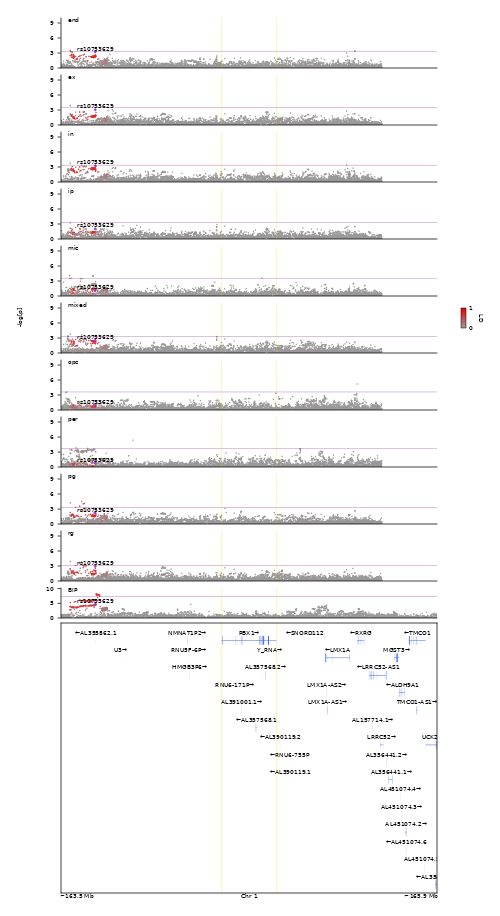

In [9]:
coloc("PBX1",
      glob("*header*", "../locuszoom/PBX1/"),
      [3.35424575002352, 3.53618462383558, 3.3661711285955, 3.29824814785822, 3.56262048947182, 3.33456817676205, 3.60527521982032, 3.6469574658058, 3.31535478295745, 3.1441260429044],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/PBX1/",
      "PBX1_rs10753629";
      snp = "rs10753629")

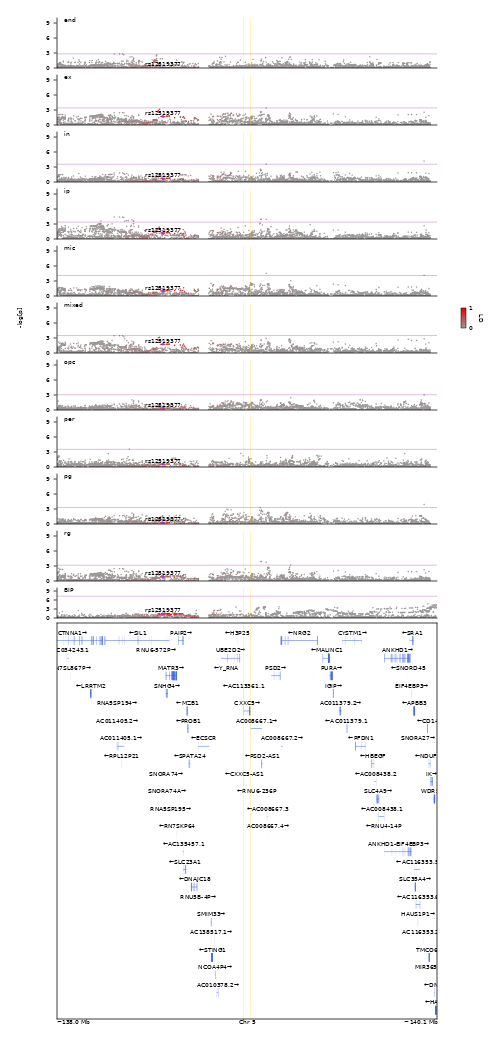

In [7]:
coloc("CXXC5",
      glob("*header*", "../locuszoom/CXXC5/"),
      [2.81054056806633, 3.40908797963201, 3.57230458414426, 3.39121517835784, 4.1292819009394, 3.44739991385609, 3.0263125444151, 3.56615659018574, 3.29288735136182, 3.18430340140716],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CXXC5/",
      "CXXC5_rs12519377";
      snp = "rs12519377")

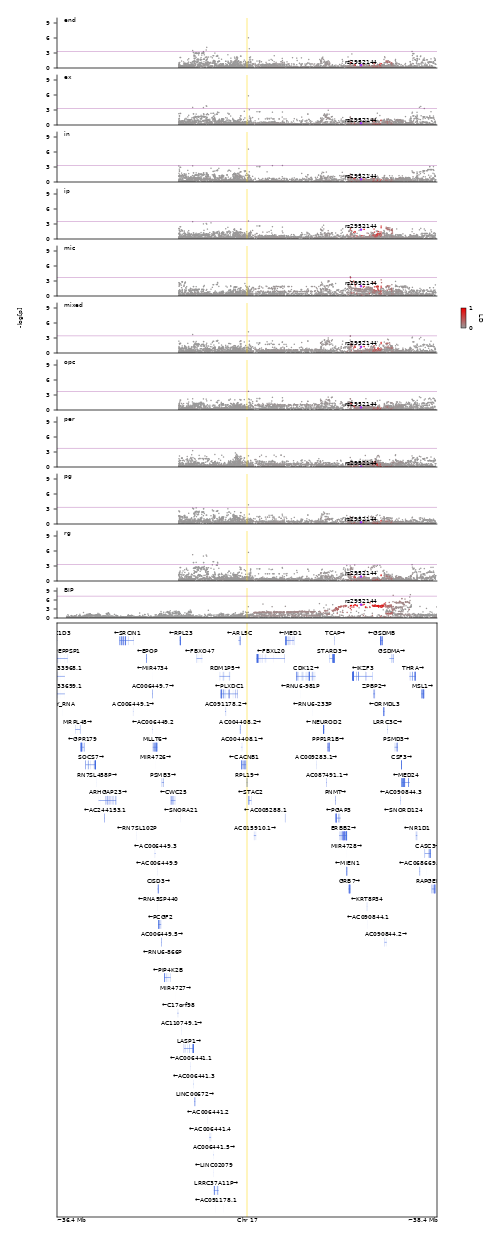

In [8]:
coloc("RPL19",
      glob("*header*", "../locuszoom/RPL19/"),
      [3.30248471005179, 3.29877751574344, 3.30148189695458, 3.46272757871874, 3.66822864370907, 3.42056626561364, 3.72551886031108, 3.75685277099749, 3.36049657756109, 3.26330716297974],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/RPL19/",
      "RPL19_rs2952144";
      snp = "rs2952144")

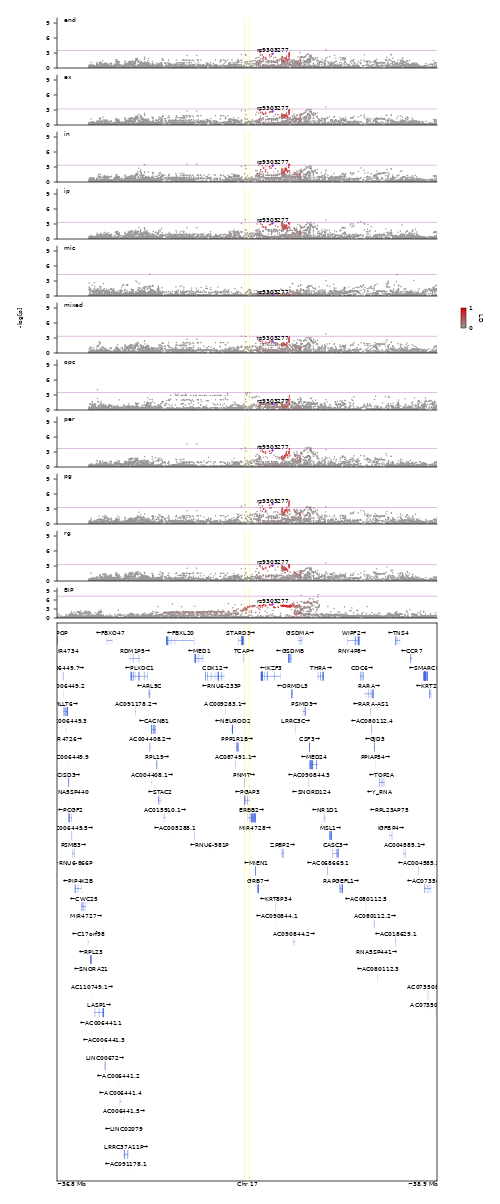

In [9]:
coloc("PGAP3",
      glob("*header*", "../locuszoom/PGAP3/"),
      [3.46956080127516, 3.19988736881527, 3.37629700553816, 3.35772249417977, 4.28671195085684, 3.36905981738072, 3.45719821722356, 3.65590849584999, 3.33384158437409, 3.23780700732835],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/PGAP3/",
      "PGAP3_rs9303277";
      snp = "rs9303277")

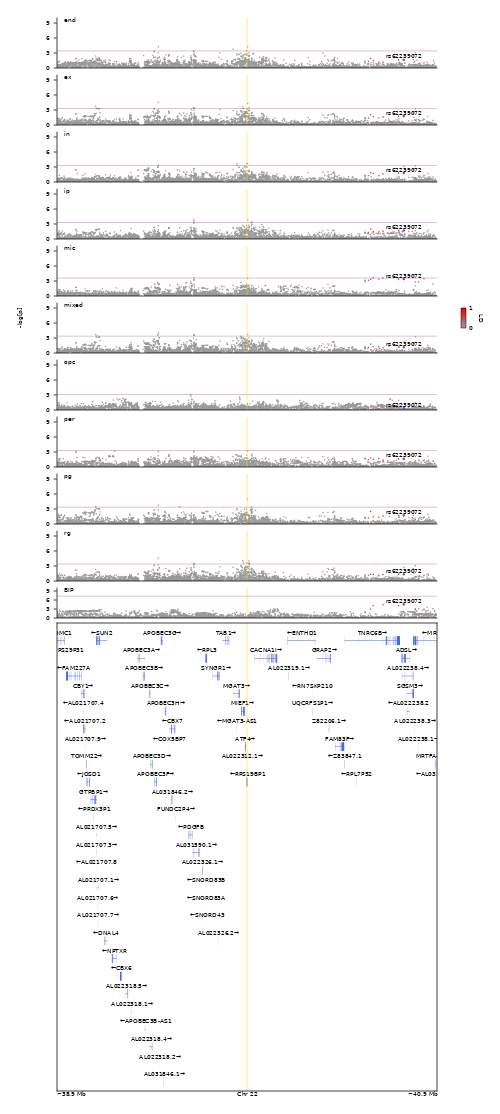

In [3]:
coloc("RPS19BP1",
      glob("*header*", "../locuszoom/RPS19BP1/"),
      [3.4070397760474, 3.30392769954835, 3.35127416464093, 3.33938492985691, 3.5960563015468, 3.38673550764461, 3.08139256104098, 3.26793610752693, 3.38226491738747, 3.40194305271921],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/RPS19BP1/",
      "RPS19BP1_rs62239072";
      snp = "rs62239072")

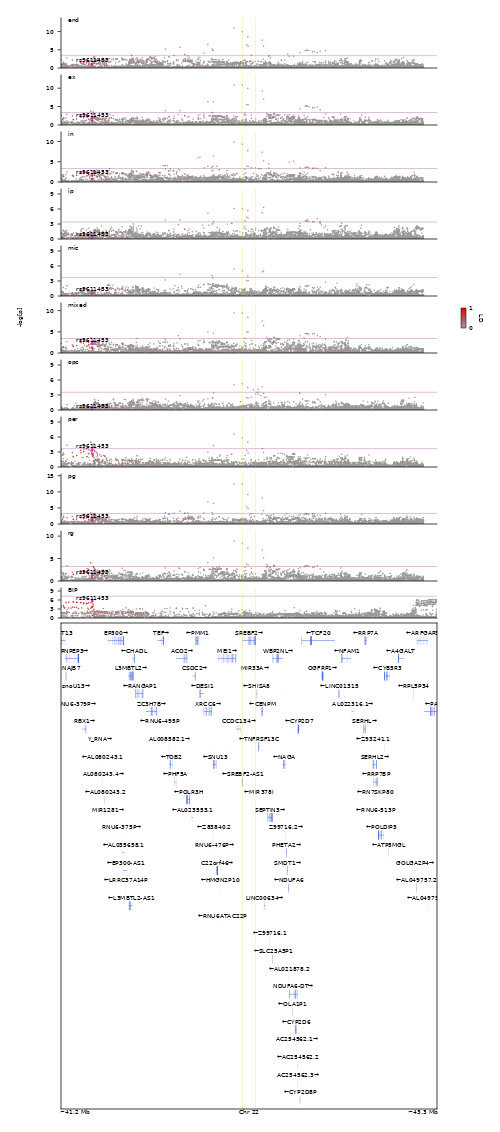

In [4]:
coloc("SREBF2",
      glob("*header*", "../locuszoom/SREBF2/"),
      [3.35221715447744, 3.33739986472478, 3.37398110896087, 3.4022752040965, 3.64793910137109, 3.40744021055058, 3.57241814893804, 3.6392551587896, 3.35420157055519, 3.27563236465719],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/SREBF2/",
      "SREBF2_rs9611453";
      snp = "rs9611453")

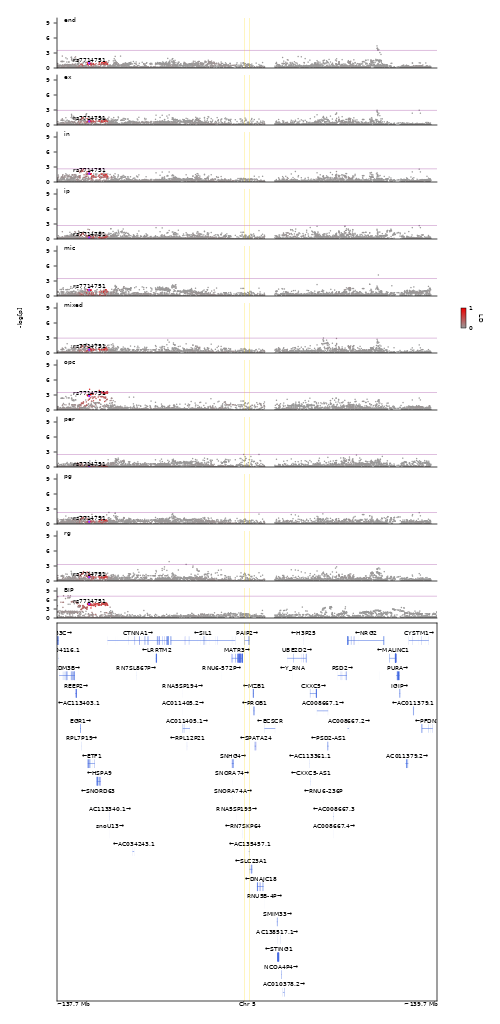

In [5]:
coloc("PAIP2",
      glob("*header*", "../locuszoom/PAIP2/"),
      [3.55537601042637, 2.96049863407574, 2.61805144079248, 2.67013045030665, 3.44925447171957, 2.98747912433048, 3.54114770022068, 2.51274988233896, 2.30681581863507, 3.32012894942137],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/PAIP2/",
      "PAIP2_rs7714751_BIP";
      snp = "rs7714751")

### MDD

In [2]:
using CairoMakie,CSV,DataFrames,Glob,SnpArrays
import GeneticsMakie as GM

gencodefilename = "/u/project/gandalm/shared/refGenomes/hg19/Gencode/v33/gencode.v33lift37.annotation.gtf"
sumstatsfilename = "/u/project/gandalm/shared/GWAS/MDD.Howard.PGC.2019/MDD.Howard.PGC.2019.sumstats_coord_withP.tsv"
ldfolder = "/u/project/gandalm/shared/apps/ldsc/LDSCORE/1000G_EUR_Phase3_plink"

function loaddata(gencodefilename::AbstractString, sumstatsfilename::AbstractString)
    gencode = CSV.read(gencodefilename, DataFrame; delim = '\t', comment = "#", 
                                        header = ["seqnames", "source", "feature", 
                                                  "start", "end", "score", "strand", 
                                                  "phase", "info"])
    GM.parsegtf!(gencode)
    sumstats = CSV.read(sumstatsfilename, DataFrame)
    GM.mungesumstats!(sumstats)
    return (gencode, sumstats)
end

gencode, sumstats = loaddata(gencodefilename, sumstatsfilename)

(2915984×14 DataFrame
     Row │ seqnames  source   feature      start  end    score    strand   pha ⋯
         │ String    String7  String15     Int64  Int64  String1  String1  Str ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │ 1         HAVANA   gene         11869  14409  .        +        .   ⋯
       2 │ 1         HAVANA   transcript   11869  14409  .        +        .
       3 │ 1         HAVANA   exon         11869  12227  .        +        .
       4 │ 1         HAVANA   exon         12613  12721  .        +        .
       5 │ 1         HAVANA   exon         13221  14409  .        +        .   ⋯
       6 │ 1         HAVANA   transcript   12010  13670  .        +        .
       7 │ 1         HAVANA   exon         12010  12057  .        +        .
       8 │ 1         HAVANA   exon         12179  12227  .        +        .
       9 │ 1         HAVANA   exon         12613  12697  .        +        .   ⋯
      10 │ 1         HAVANA   

In [3]:
# coloclocuszoom
# saves LocusZoom style plot with PGC3 summary statistics and an array of provided eQTLs
# @param gene::AbstractString - gene to visualize
# @param colocfilenames::Array{<:AbstractString} - array of eQTL filenames to visualize
# @param colocthresholds::Array{<:Real} - array of signficance thresholds
# @param ldfilename::AbstractString - filename for the LD reference file
# @param outpath::AbstractString - output path
# @param outname::AbstractString - filename for output, without extension
# @param snp::Union{AbstractString, Nothing} - optional SNP ID to visualize LD of
# @return - Makie figure visualizing the LocusZoom plot
# side effect - Saves image to <outpath>/<outname>.png
function coloc(gene::AbstractString, colocfilenames::Array{<:AbstractString}, colocthresholds::Array{<:Real}, 
               ldfilename::AbstractString, outpath::AbstractString, outname::AbstractString;
               snp::Union{AbstractString, Nothing} = nothing)
    colocfiles = [CSV.read(file, DataFrame; header = 1) for file in colocfilenames]
    ld = SnpData(ldfilename)
    colocfiles = [innerjoin(df, ld.snp_info, on = :MarkerName => :snpid)
                   for df in colocfiles]
    colocfiles = DataFrame[colocfiles...]
    GM.mungesumstats!(colocfiles)
    chr, start, stop = GM.findgene(gene, gencode)
    range1 = start - 1e6
    range2 = stop + 1e6
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    f = Figure(resolution = (500, 1000))
    n = length(colocfiles)
    axs = [Axis(f[i,1]) for i in 1:(n+2)]
    # Visualize eQTLs
    for i in 1:n
        title = match(r"[^_]*", basename(colocfilenames[i])).match
        if isnothing(snp)
            GM.plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = ld)
        else
            GM.plotlocus!(axs[i], chr, range1, range2, colocfiles[i], ld = (ld, snp))
        end
        lines!(axs[i], [range1, range2], fill(colocthresholds[i], 2), color = (:purple, 0.5), linewidth = 0.5)
        vlines!(axs[i], start, color = (:gold, 0.5), linewidth = 0.5)
        vlines!(axs[i], stop, color = (:gold, 0.5), linewidth = 0.5)
        Label(f[i, 1, Top()], title, textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
        rowsize!(f.layout, i, 50)
    end
    # Visualize PGC3
    ld = SnpData(joinpath(ldfolder, "1000G.EUR.QC.$(chr)"))
    colinds = findall(row -> row.chromosome == chr &&
                      range1 <= row.position <= range2,
    eachrow(ld.snp_info))
    SnpArrays.filter(ld, trues(size(ld)[1]), colinds;
                         des = joinpath(outpath, "ld.tmp"))
    ld = SnpData(joinpath(outpath, "ld.tmp"))
    if isnothing(snp)
        GM.plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = ld)
    else
        GM.plotlocus!(axs[n + 1], chr, range1, range2, sumstats, ld = (ld, snp))
    end
    lines!(axs[n + 1], [range1, range2], fill(7.3, 2), color = (:purple, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 1], stop, color = (:gold, 0.5), linewidth = 0.5)
    Label(f[n + 1, 1, Top()], "MDD", textsize = 6, halign = :left, padding = (7.5, 0, -5, 0))
    rowsize!(f.layout, n + 1, 30)
    # Visualize genes
    rs = GM.plotgenes!(axs[n + 2], chr, range1, range2, gencode)
    vlines!(axs[n + 2], start, color = (:gold, 0.5), linewidth = 0.5)
    vlines!(axs[n + 2], stop, color = (:gold, 0.5), linewidth = 0.5)
    rowsize!(f.layout, n + 2, rs)
    Colorbar(f[1:(n+1), 2], limits = (0, 1), ticks = 0:1:1, height = 20,
        colormap = (:gray60, :red2), label = "LD", ticksize = 0, tickwidth = 0,
        tickalign = 0, ticklabelsize = 6, flip_vertical_label = true,
        labelsize = 6, width = 5, spinewidth = 0.5)
    GM.labelgenome(f[n + 2, 1, Bottom()], chr, range1, range2)
    Label(f[1:(n + 1), 0], text = "-log[p]", textsize = 6, rotation = pi / 2)
    rowgap!(f.layout, 5)
    rowgap!(f.layout, 5)
    resize_to_layout!(f)
    save(joinpath(outpath, outname * ".png"), f, px_per_unit = 4)
    return f
end

coloc (generic function with 1 method)

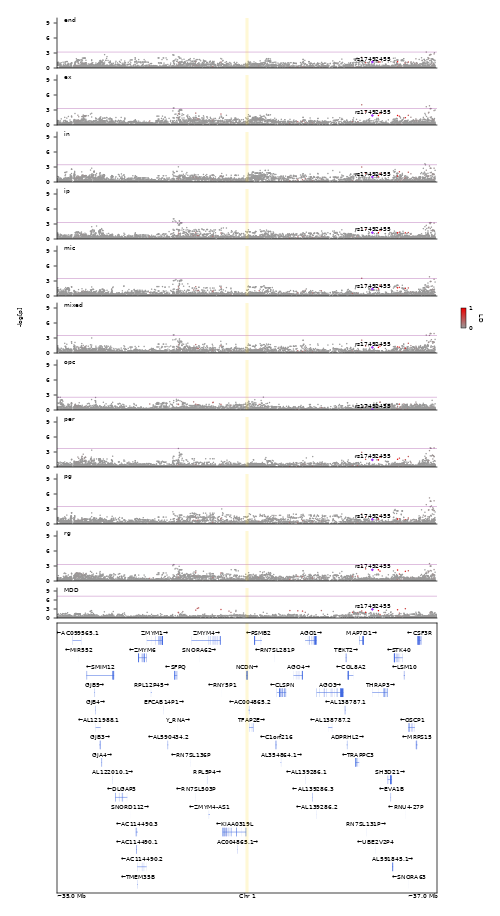

In [8]:
coloc("NCDN",
      glob("*header*", "../locuszoom/NCDN/"),
      [3.19251841644076, 3.28573899501642, 3.42857768746288, 3.27372769390209, 3.54671530378637, 3.53020890100066, 2.5736937349669, 3.70515475830393, 3.45707503270532, 3.27181591009223],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/NCDN/",
      "NCDN_rs17492455";
      snp = "rs17492455")

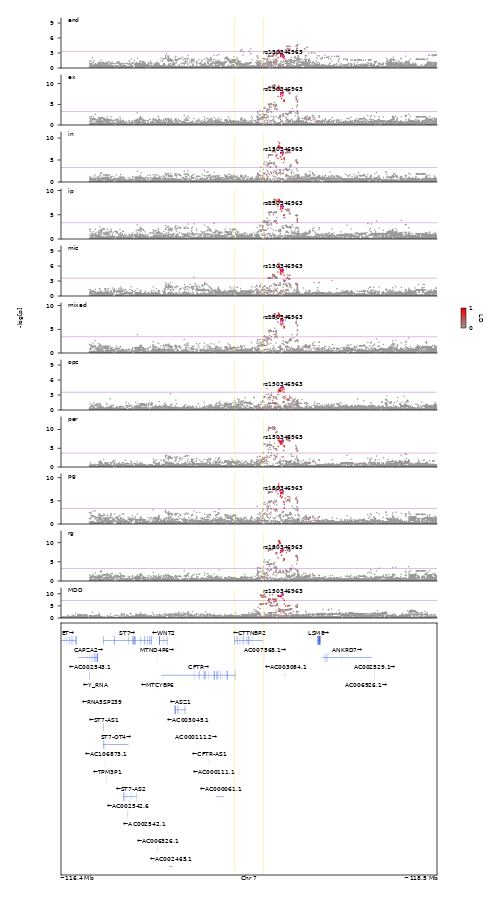

In [9]:
coloc("CTTNBP2",
      glob("*header*", "../locuszoom/CTTNBP2/"),
      [3.35853580500822, 3.29553546276184, 3.33913736672913, 3.3431603916155, 3.58174346652473, 3.40694443610883, 3.57419361563098, 3.71459348260932, 3.3733671213976, 3.27982911556227],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CTTNBP2/",
      "CTTNBP2_rs150346963";
      snp = "rs150346963")

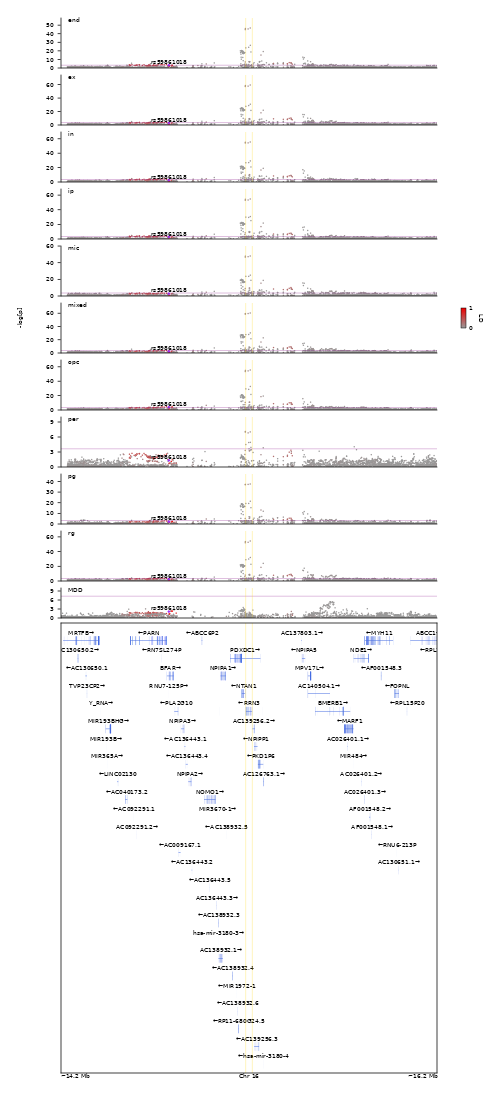

In [10]:
coloc("RRN3",
      glob("*header*", "../locuszoom/RRN3/"),
      [3.36708739292272, 3.29344777599265, 3.34141437812442, 3.35749096438178, 3.59043880547815, 3.40401794883148, 3.56432441759764, 3.61996613141798, 3.35468877488331, 3.3047609307189],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/RRN3/",
      "RRN3_rs59861018";
      snp = "rs59861018")

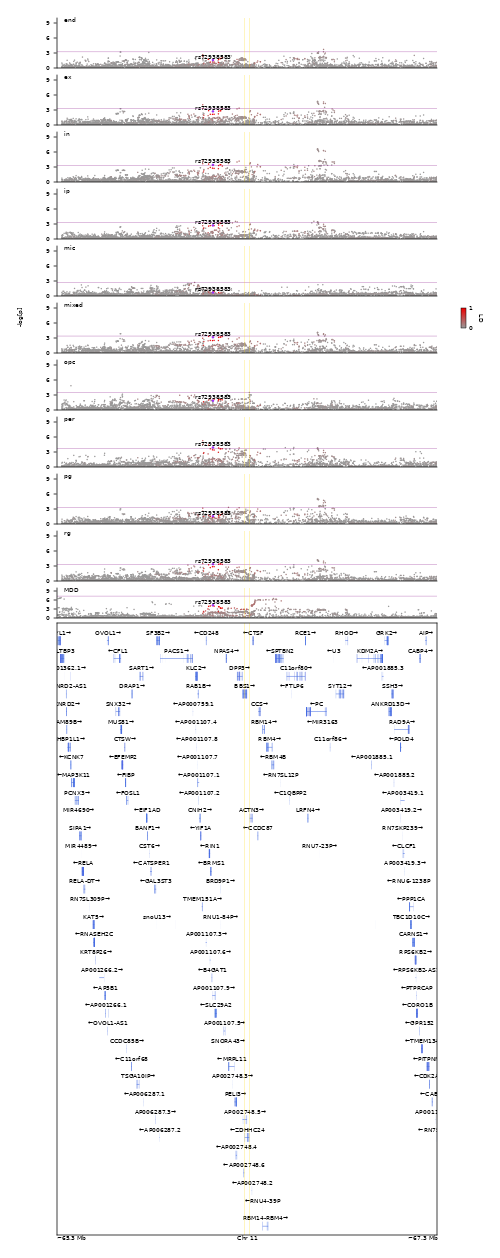

In [12]:
coloc("ZDHHC24",
      glob("*header*", "../locuszoom/ZDHHC24/"),
      [3.23561312521445, 3.29772114843118, 3.3268712241995, 3.34182827805396, 2.7105225336554, 3.38967100624161, 3.50698413664333, 3.65970265786562, 3.32707961001956, 3.32916991288498],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/ZDHHC24/",
      "ZDHHC24_rs72938583";
      snp = "rs72938583")

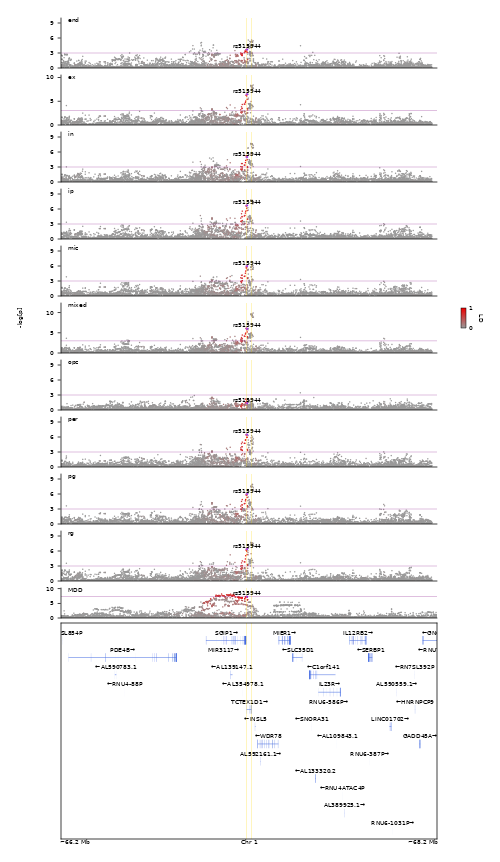

In [13]:
coloc("TCTEX1D1",
      glob("*header*", "../locuszoom/TCTEX1D1/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/TCTEX1D1/",
      "TCTEX1D1_rs515944";
      snp = "rs515944")

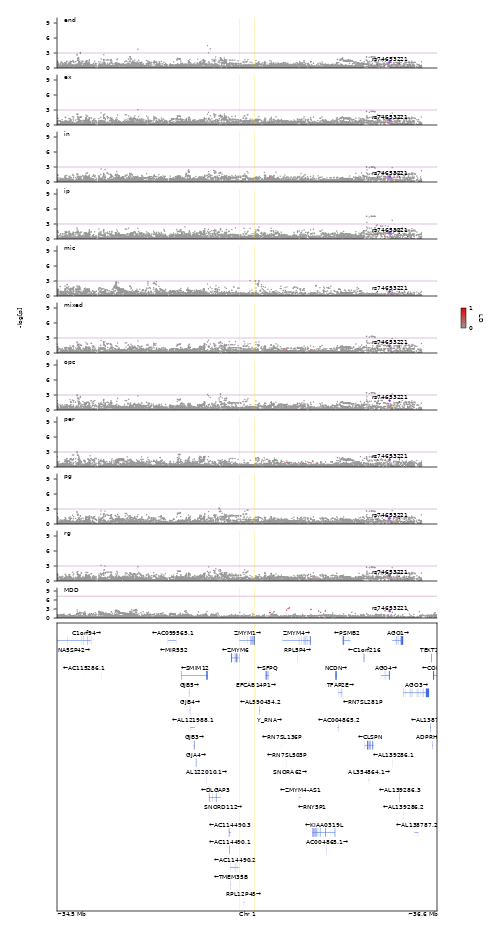

In [5]:
coloc("ZMYM1",
      glob("*header*", "../locuszoom/ZMYM1/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/ZMYM1/",
      "ZMYM1_rs74653221";
      snp = "rs74653221")

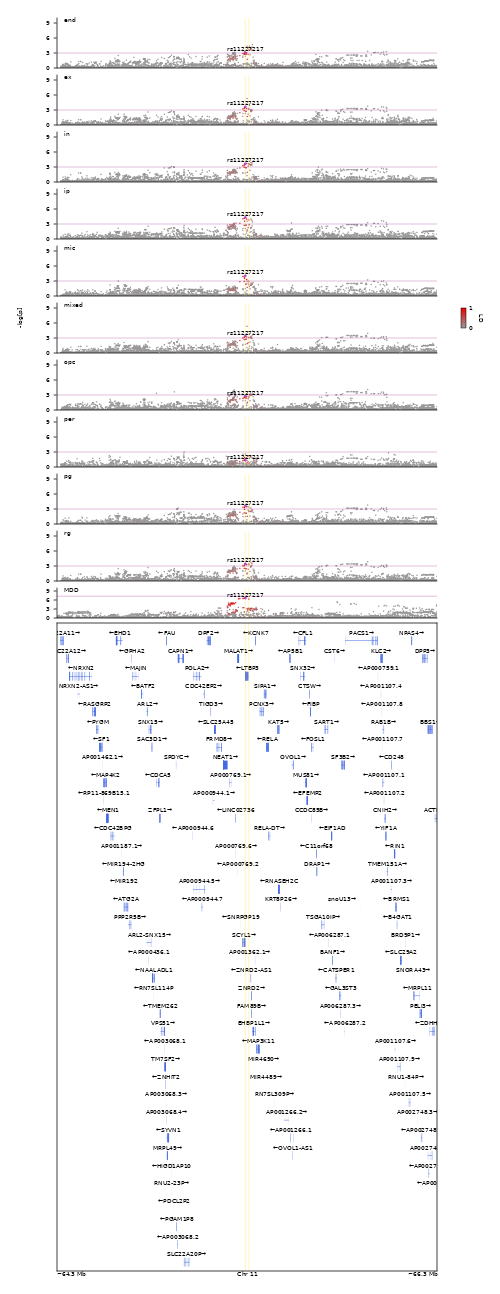

In [15]:
coloc("LTBP3",
      glob("*header*", "../locuszoom/LTBP3/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/LTBP3/",
      "LTBP3_rs11227217";
      snp = "rs11227217")

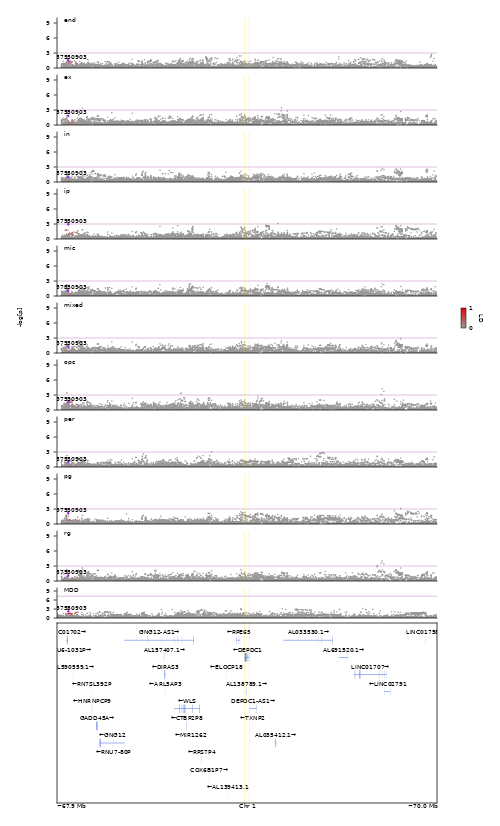

In [16]:
coloc("DEPDC1",
      glob("*header*", "../locuszoom/DEPDC1/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/DEPDC1/",
      "DEPDC1_rs57550903";
      snp = "rs57550903")

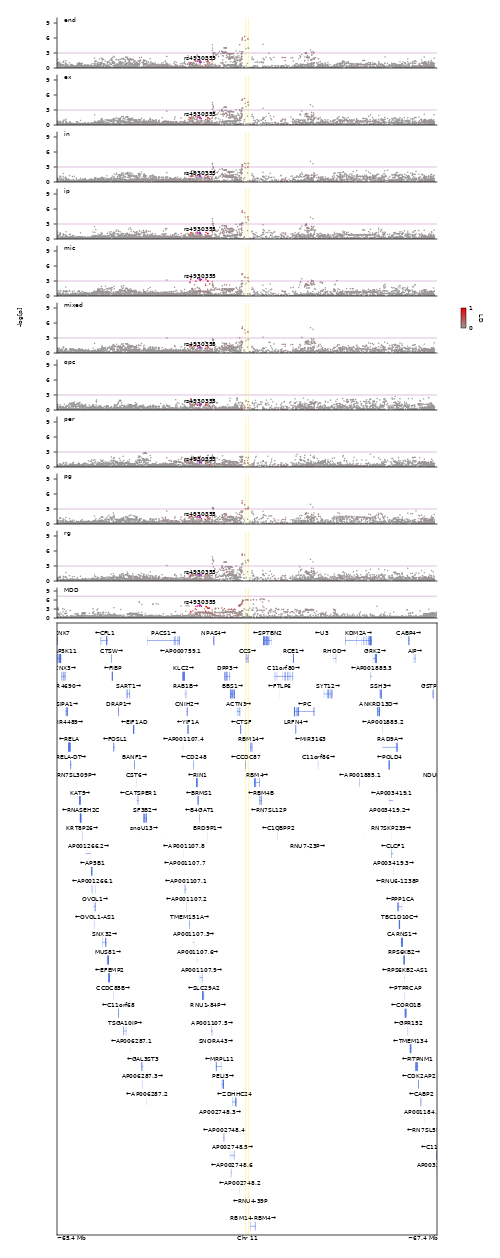

In [17]:
coloc("CCS",
      glob("*header*", "../locuszoom/CCS/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/CCS/",
      "CCS_rs4930355";
      snp = "rs4930355")

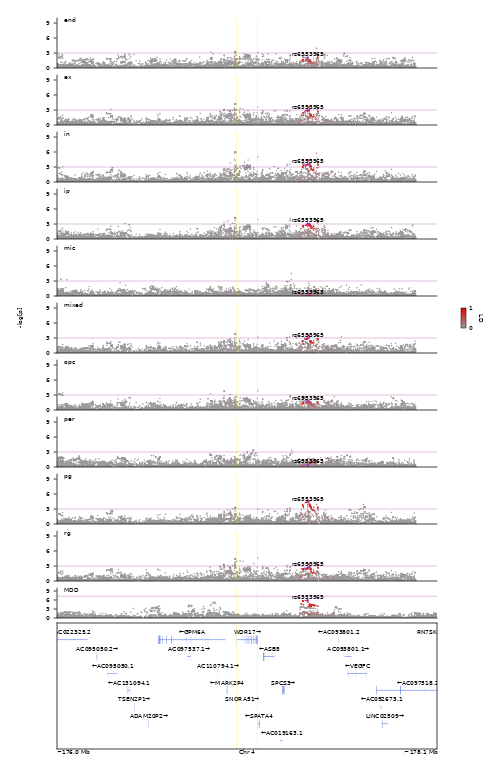

In [6]:
coloc("WDR17",
      glob("*header*", "../locuszoom/WDR17/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/WDR17/",
      "WDR17_rs6553965";
      snp = "rs6553965")

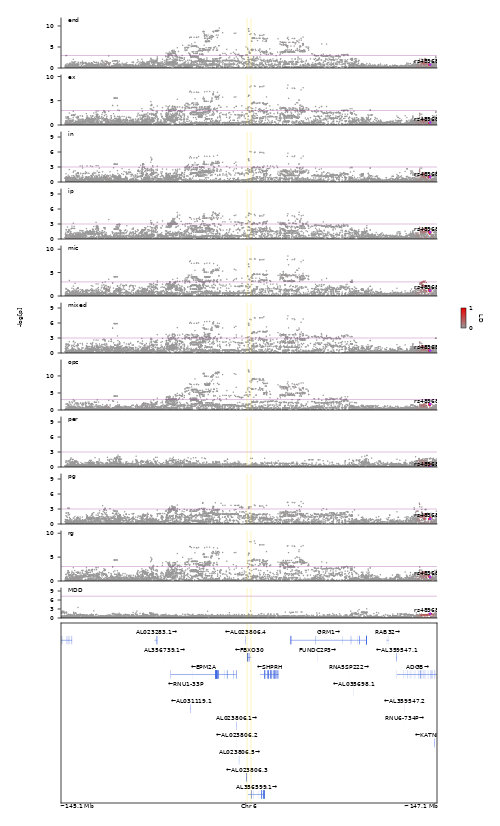

In [19]:
coloc("FBXO30",
      glob("*header*", "../locuszoom/FBXO30/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/FBXO30/",
      "FBXO30_rs4896888";
      snp = "rs4896888")

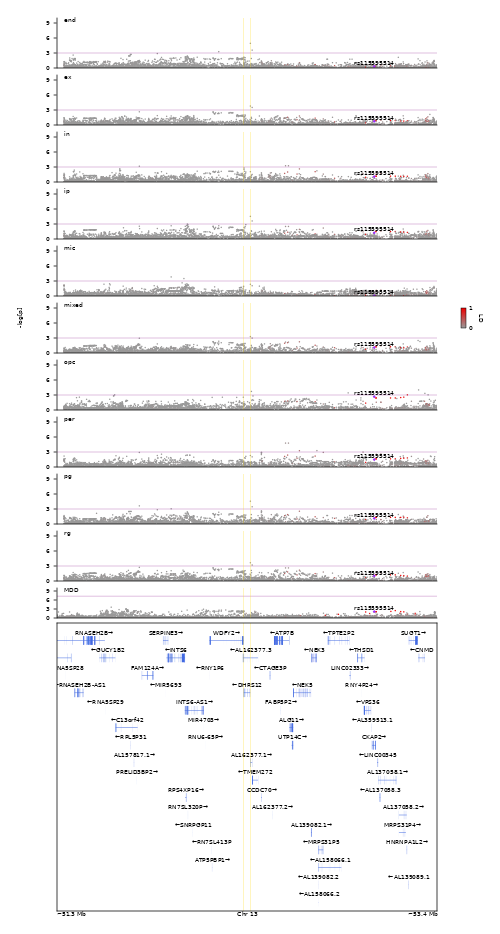

In [20]:
coloc("DHRS12",
      glob("*header*", "../locuszoom/DHRS12/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/DHRS12/",
      "DHRS12_rs115595514";
      snp = "rs115595514")

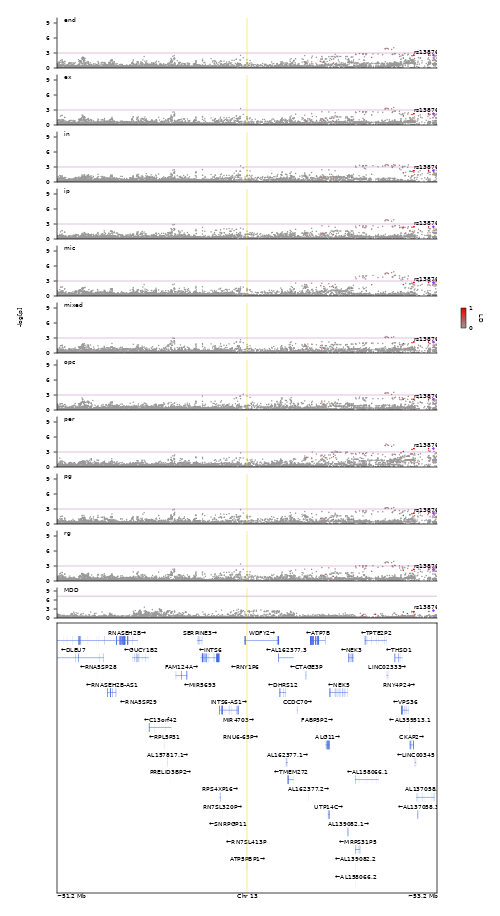

In [4]:
coloc("ATP5PBP1",
      glob("*header*", "../locuszoom/ATP5PBP1/"),
      [3,3,3,3,3,3,3,3,3,3],
      "/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/filtered.hg19.sorted.removeGeneOutlier",
      "../locuszoom/ATP5PBP1/",
      "ATP5PBP1_rs138763571";
      snp = "rs138763571")